# Método Colônia de Formigas aplicado ao Problema do Caixeiro Viajante

O método colônia de formigas (Ant Colony Optimization - ACO) é uma meta-heurística inspirada no comportamento de forrageamento das formigas. Esta técnica é amplamente utilizada para resolver problemas de otimização combinatória, como o problema do caixeiro viajante (Travelling Salesman Problem - TSP).

A seguir, apresentamos um passo a passo da aplicação do ACO ao TSP.

## Passo 1: Inicialização

Inicialmente, são definidas as seguintes variáveis:

- $\alpha$: parâmetro que controla a influência do feromônio.
- $\beta$: parâmetro que controla a influência da visibilidade (heurística).
- $\rho$: taxa de evaporação do feromônio.
- $Q$: quantidade de feromônio depositada por uma formiga.
- $m$: número de formigas.
- $n$: número de cidades.

Os vetores e matrizes necessários são inicializados:

- Matriz de feromônio $\tau_{ij}$: inicializada com um pequeno valor positivo.
- Matriz de visibilidade $\eta_{ij} = \frac{1}{d_{ij}}$, onde $d_{ij}$ é a distância entre as cidades $i$ e $j$.

\begin{equation}
\tau_{ij} = \tau_0, \quad \eta_{ij} = \frac{1}{d_{ij}}
\end{equation}

## Passo 2: Construção das Soluções

Cada formiga constrói uma solução (um tour) de forma probabilística. A probabilidade de uma formiga se mover da cidade $i$ para a cidade $j$ é dada por:

\begin{equation}
P_{ij} = \frac{[\tau_{ij}]^\alpha [\eta_{ij}]^\beta}{\sum_{k \in \text{não visitadas}} [\tau_{ik}]^\alpha [\eta_{ik}]^\beta}
\end{equation}

## Passo 3: Atualização do Feromônio

Após todas as formigas completarem seus tours, a quantidade de feromônio nos caminhos percorridos é atualizada. O feromônio evapora ao longo do tempo e é depositado pelas formigas nos caminhos que percorreram. A atualização é feita da seguinte forma:

1. **Evaporação do Feromônio:**

\begin{equation}
\tau_{ij} \leftarrow (1 - \rho) \tau_{ij}
\end{equation}

2. **Deposição do Feromônio:**

\begin{equation}
\tau_{ij} \leftarrow \tau_{ij} + \sum_{\text{todas asn}

ond\begin{equation}
\Delta \tau_{ij}^k = \begin{cases}
\frac{Q}{L_k} & \text{se a formiga } k \text{ percorrer a aresta } (i,j) \\
0 & \text{caso contrário}
\end{cases}
\end{equation}ses}
\end{ehile
\State \textbf{Retornar} melhor solução encontrada
\end{algorithmic}
\end{algorithm}


### 0) Importação das Bibliotecas:

In [1]:

import locale
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
### from prettytable import PrettyTable
from itertools import product
from math import sqrt
import random
import folium
from pyproj import Proj
### import gurobipy as gp
### from gurobipy import GRB
# importing googlemaps module
#import googlemaps
import pandas as pd
import geopy.distance as gd
import sys
import time
import os

# Chamando o arquivo .py com as funções implementadas
import Modulo

### 1) Carregamento dos bancos de dados:

In [2]:
# Carregamento dos dados dos postos de saúde já tratados:
cab = ['Índice','Região','Endereço','CoordenadaXY','X','Y']
postos_data = pd.read_csv('../Banco_de_dados/postos_data.csv', sep=',', skiprows=1, names = cab)
postos_data.head()

,Índice,Região,Endereço,CoordenadaXY,X,Y
0,0,Centro,Rua Coronel José Monteiro 407 Centro,-23.181409264128344 -45.88413629003892,-45.884136,-23.181409
1,1,Centro,Avenida Anchieta 1069 Jardim Nova América,-23.19300408207269 -45.90407824956441,-45.904078,-23.193004
2,2,Centro,Rua Martins Pereira 263 Jardim Paulista,-23.190159425525938 -45.87033204771088,-45.870332,-23.190159
3,3,Centro,Rua São Pedro 55 Vila Maria,-23.17685304237057 -45.878886747711434,-45.878887,-23.176853
4,4,Leste,Rua Júlia Cursino 161 Americano,-23.179259398036233 -45.81191067654758,-45.811911,-23.179259


In [3]:
postos_data['Região'].value_counts()

Região
Leste      10
Sul         9
Norte       5
Centro      4
Sudeste     4
Oeste       2
Name: count, dtype: int64

In [4]:
# Carregamento dos dados do público alvo já tratados:
cab = ['Índice', 'id', 'oms_id', 'Nome', 'loteamento', 'Região', 'X', 'Y','clusters']
publico_data = pd.read_csv('../Banco_de_dados/publico_data_clean_clusters.csv', sep=',', skiprows=1, names = cab)
publico_data.head()

#### Atenção! usar o "publico_data_clean.csv"

,Índice,id,oms_id,Nome,loteamento,Região,X,Y,clusters
0,0,2779,131745502.0,Sem nome,Altos da Quinta,Sul,-45.870127,-23.260867,9
1,1,2226,256249039.0,Gentil Pereira do Nascimento,Altos da Quinta,Sul,-45.869097,-23.258867,9
2,2,2827,131745503.0,Doze,Altos da Quinta,Sul,-45.869010,-23.257458,9
3,3,2828,131745505.0,Treze,Altos da Quinta,Sul,-45.867334,-23.258407,9
4,4,7804,319795429.0,Cinco,Altos da Quinta,Sul,-45.870646,-23.256537,1


In [5]:
publico_data['Região'].value_counts()

Região
Sul        1720
Leste      1408
Sudeste     796
Centro      698
Norte       517
Oeste       418
Name: count, dtype: int64

### 2) Mapas São José:

#### 2.1) Sub-região que será usada no Otimizador:

In [6]:
# Usando a função mapa_regiao para plot do mapa personalizado:

Modulo.Region_map(postos_data, 
                  publico_data, 
                  postos_data.X,
                  postos_data.Y, 
                  publico_data.X, 
                  publico_data.Y, 
                  regiao='Sudeste', 
                  cor='red')

### 3) Material e versões do Otimizador:

Links:

https://induraj2020.medium.com/implementation-of-ant-colony-optimization-using-python-solve-traveling-salesman-problem-9c14d3114475

http://www.lac.inpe.br/~lorena/cap/Aula_C03.pdf

https://www.ime.unicamp.br/~chico/mt852/formigas.pdf

#### 3.1) Últimas versõs do Otimizador:

##### Versão 2.0:

###### Adaptação para o cálculo de distância usando o "gd.geodesic";

###### Adaptação da saída da função (gráfico 3D p/ índices com o melhor caminho).

##### Versão 2.5:

###### Adição da parada do algoritmo utilizando o cálculo de tempo do agente;

###### Imposição do ponto inicial sendo o posto de saúde;

###### Adição do condicional para cálculo do tempo total;

###### Adição do condicional para o fator de exploração aleatória, a fim de evitar mínimos locais. [desativado devido inconsistências];

##### Versão 3.0:

###### Adição da variável "radius". Permite que a busca por pontos esteja dentro de uma vizinhança (raio), evitando escolha de pontos longínquos, que poderiam ser abordados por outro posto;

###### Adição do "incremento do raio", para a solução do prblema de não existir pontos dentro do raio escolhido inicialmente.

##### Versão 3.1:

###### Atualização de bug: o raio da versão 3.0 não estava atualizando. Nova abordagem de condicional na variável "probabilities"

##### Versão 3.2:

###### União das funções "ant_colony_optimization_3_1" e "best_way"

###### Atualização das saídas da nova função

##### Versão 3.3:

###### Adição do relatório .txt

###### Retirada informações desnecessárias para otimizar a execução do script

###### Loop para geração de sequência de índices do Otimizador;

##### Versão 4.0:

###### Super loop para gerar as sequências de coordenadas dos agentes;

###### Super loop para geração dos .html com os caminhos;

###### Adaptação do best_way para a variável "seq_points";



### 4) Super loop para geração dos caminhos:

In [7]:
# Função para usar os pontos e postos de uma região:
# Função para usar os pontos e postos de uma região:
def Region_data_cluster(postos_data, publico_data, n, regiao='Norte'):
    '''
    Função para gerar uma subregião do banco de dados (Banco de dados na região Central, por exemplo)
    
    input: 
        latitude e longitude, n=índice da coordenada de um posto

    operação:
        mask = escolha de uma subregião (Centro, por exemplo)
        stack das primeiras m coordenadas do público e uma coordenada do posto

    output: 
        coordenadas da subregião com m públicos e posto co índice n
    '''
    
    # Criar uma máscara booleana com base na condição da região
    mask_posto = postos_data['Região'] == regiao
    mask_publico = publico_data['Região'] == regiao
    
    # Aplicar a máscara ao DataFrame para filtrar a região desejada
    mask_postos = postos_data[mask_posto]
    mask_publico = publico_data[mask_publico]
    
    # Adicionar filtro para selecionar todas as linhas cujo cluster seja igual a 'n'
    mask_publico = mask_publico[mask_publico['clusters'] == n]

    # Criar listas de coordenadas
    points2 = np.array((mask_publico.Y, mask_publico.X)).T
    points1 = np.array((mask_postos.Y.iloc[n-1], mask_postos.X.iloc[n-1])).T

    # Criar a pilha de coordenadas
    stack = np.vstack((points1, points2))
    stack_data = pd.DataFrame(stack, columns=['Latitude', 'Longitude'])

    # Adicionar índice das linhas
    stack_data['indices'] = range(len(stack_data))
    
    return stack_data



In [8]:
points = Region_data_cluster(postos_data, publico_data, n=1, regiao='Sudeste')
points

,Latitude,Longitude,indices
0,-23.205980,-45.857299,0
1,-23.209051,-45.849709,1
2,-23.208427,-45.849803,2
3,-23.211370,-45.845023,3
4,-23.211015,-45.845519,4
...,...,...,...
429,-23.195890,-45.864634,429
430,-23.193551,-45.867893,430
431,-23.194478,-45.866892,431
432,-23.193755,-45.866839,432


#### 4.1) Hiperprâmetros:

In [9]:
# Aqui pode-se alterar os inputs que serão usados na função "ant_colony_optimization_4"
n_ants = 4
n_iterations = 25
alpha = 0.8
beta = 0.8
evaporation_rate = 0.5
Q = 1
radius = 0.2
regiao = 'Sul'
v = 'bike'

#### 4.2) Super loop para geração das sequências de coordenadas + Mapas com os caminhos:

In [10]:
mask_posto = postos_data['Região'] == regiao
mask_posto = postos_data[mask_posto]

for n in range(0, len(mask_posto)):
# Gerando o "new_points" fora do loop para usar o len() para o "super_ite":
    points = Modulo.Region_data_cluster(postos_data, publico_data, n+1, regiao=regiao)
    new_points = np.array([points['Latitude'][:], points['Longitude'][:]]).T
    
    # Inicializa variáveis de controle
    # Lista vazia que será preenchida com os índices dos melhores caminhos:
    all_best_paths = [] 
    #exec(f'all_best_paths_{i} = []')
    # Lista vazia que será preenchida com as distâncias de cada caminho:
    exec(f'all_paths_length_{n} = []')
    # Lista vazia que será preenchida com as coordenadas dos melhores caminhos:
    exec(f'seq_coord_{n} = []')
    # Lista vazia que será preenchida com as coordenadas não visitadas:
    exec(f'visited_coord_{n} = []')
    # Lista vazia que será preenchida com as coordenadas que tiveram visitas:
    exec(f'no_visit_coord_{n} = []')
    # Cronometrar o Super loop:
    start_time = time.time() 
    # Print do ínicio so Super loop e da quatidade de amostras iniciais
    super_ite = len(new_points) -1
    
    print('Inicio da geração de caminhos, quantidade de amostras:', super_ite)
    
    # Super loop:
    while super_ite > 1:
        # Passando por todos os pontos de saídas dos agentes
        #for i in range(0, 4):
            # Chama a função Region_data com a versão filtrada de publico_data
        points = Modulo.Region_data_cluster(postos_data, publico_data, n+1, regiao=regiao)
    
        # Condicional para drop de coordenadas usadas
        if len(all_best_paths) > 0:
            for k in range(len(all_best_paths)):
                points = points.drop(points['indices'].iloc[all_best_paths[k]][1:])
        
        # Transforma DF em array para entrar em "ant_colony_optimization"
        new_points = np.array([points['Latitude'][:], points['Longitude'][:]]).T
    
        # Print da quantidade de amostras restantes
        print('Quantidade de Coordenadas remanescentes:', len(new_points)-1)
                
        # Aplica o algoritmo de otimização
        best_path, path_length = Modulo.ant_colony_optimization_4(new_points, 
                                                                  n_ants, 
                                                                  n_iterations, 
                                                                  alpha, 
                                                                  beta, 
                                                                  evaporation_rate, 
                                                                  Q, 
                                                                  radius,
                                                                  veiculo = v)
    
        # Adição de imprevisibiidade nas visitas 
        # obs: o path_leght permanece sem alteração -> não ter atendimento não altera o fato de que o agente visitou!
        visited, no_visited = Modulo.filter_list_with_probability(best_path, probability=0.2)
        #Prints
        print('caminho antes:',best_path)
        print('visitado:',visited)
        print('não visitado:',no_visited)
        # Adicionar "best_path" para a super variável "all_best_paths"
        all_best_paths.append(visited)
        #globals()[f'all_best_paths_{k}'].append(visited)
        # Adicionar "path_length" para a super variável "all_paths_length"
        globals()[f'all_paths_length_{n}'].append(path_length)
        # Adicionar a sequência de melhor caminho da rodada na super variável "seq_coord"
        globals()[f'seq_coord_{n}'].append(new_points[best_path])
        #seq_coord.append(new_points[best_path])
        # Adicionar as coordenadas que tiveram visitas
        globals()[f'visited_coord_{n}'].append(new_points[visited])
        # Adicionar os locais não visitados na rodada: 
        globals()[f'no_visit_coord_{n}'].append(new_points[no_visited])
        # Subtrair a quantidade de coordenadas usadas de "super_ite" para o condicional "while"
        len_selec = len(visited) - 1
        super_ite -= len_selec
            
        print('Fim da rodada:', len(all_best_paths))

    # Defina o caminho da pasta onde deseja salvar os arquivos
    save_path = f'Carro_{regiao}_cluster_{n+1}'
    
    # Verifique se a pasta existe, se não, crie-a
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # Loop para automatização da geração dos mapas
    for i in range(len(globals()[f'seq_coord_{n}'])):
        # Crie o mapa com as coordenadas principais
        mapa = Modulo.best_way(globals()[f'seq_coord_{n}'][i])
        
        # Adicione as coordenadas da lista extra se existirem
        if i < len(globals()[f'no_visit_coord_{n}']):
            for coord in globals()[f'no_visit_coord_{n}'][i]:
                folium.CircleMarker(
                    location=coord,
                    radius=5,
                    fill=True,
                    color="yellow",
                    fill_color="yellow",
                    fill_opacity=1
                ).add_to(mapa)
        
        # Salva o mapa gerado em um arquivo .html na pasta especificada
        mapa.save(os.path.join(save_path, f'mapa_{i+1}.html'))
    
    print(new_points)
    
    #print('Sequência gerada ao final do Loop:', seq_coord)
    #print('Sequênia de não visitas gerada ao final do Loop:', no_visit_coord)
    
    print(f'\nDuração total: {time.time() - start_time:.0f} segundos')
    

Inicio da geração de caminhos, quantidade de amostras: 175
Quantidade de Coordenadas remanescentes: 175

Duration: 166 seconds
caminho antes: [0, 59, 15, 14, 37, 18, 41, 81, 78, 76, 66, 160, 80, 40, 42, 39, 79, 158, 161, 164, 165]
visitado: [0, 37, 41, 81, 78, 76, 66, 160, 80, 40, 42, 39, 158, 161, 164]
não visitado: [59, 15, 14, 18, 79, 165]
Fim da rodada: 1
Quantidade de Coordenadas remanescentes: 161

Duration: 124 seconds
caminho antes: [0, 15, 14, 54, 55, 74, 89, 75, 6, 17, 5, 50, 16, 51, 76, 53, 61, 66, 10, 4, 113]
visitado: [0, 15, 14, 54, 55, 89, 75, 6, 17, 5, 50, 16, 51, 76, 53, 66, 10, 4, 113]
não visitado: [74, 61]
Fim da rodada: 2
Quantidade de Coordenadas remanescentes: 143

Duration: 119 seconds
caminho antes: [0, 10, 133, 125, 129, 130, 128, 132, 131, 126, 127, 57, 28, 27, 25, 54, 43, 66, 105]
visitado: [0, 10, 133, 125, 129, 130, 128, 132, 131, 126, 127, 57, 28, 27, 25, 54, 43, 66, 105]
não visitado: []
Fim da rodada: 3
Quantidade de Coordenadas remanescentes: 125

Dura

In [ ]:
### Loop para comparar a quantidade de pontos usados com o original!
### Se a saída for "True", todos os pontos foram vizitados:
s = 0

for k in range(len(visited_coord_2)):
    s += len(visited_coord_2[k]) - 1

print(s)

#s == len(Region_data_cluster(postos_data, publico_data, n=1, regiao='Sudeste')) - 1


In [ ]:
# Verificação:

s_9 = 0

for k in range(len(globals()[f'visited_coord_9'])):
    s_9 += len(globals()[f'visited_coord_9'][k]) - 1

s_9

In [ ]:
s_0

In [ ]:
s_1

In [ ]:
s_2

In [ ]:
s_3

In [ ]:
s_4

In [ ]:
s_5

In [ ]:
s_6

In [ ]:
s_7

In [ ]:
s_8

In [ ]:
s_9

In [ ]:
len(Modulo.Region_data_cluster(postos_data, publico_data, n=1, regiao=regiao))

In [ ]:
len(Modulo.Region_data_cluster(postos_data, publico_data, n=2, regiao=regiao))

In [ ]:
len(Modulo.Region_data_cluster(postos_data, publico_data, n=3, regiao=regiao))

In [ ]:
len(Modulo.Region_data_cluster(postos_data, publico_data, n=4, regiao=regiao))

In [ ]:
len(Modulo.Region_data_cluster(postos_data, publico_data, n=5, regiao=regiao))

In [ ]:
len(Modulo.Region_data_cluster(postos_data, publico_data, n=6, regiao=regiao))

In [ ]:
len(Modulo.Region_data_cluster(postos_data, publico_data, n=7, regiao=regiao))

In [ ]:
len(Modulo.Region_data_cluster(postos_data, publico_data, n=8, regiao=regiao))

In [ ]:
len(Modulo.Region_data_cluster(postos_data, publico_data, n=9, regiao=regiao))

In [ ]:
len(Modulo.Region_data_cluster(postos_data, publico_data, n=10, regiao=regiao))

In [ ]:
#visited_coord_1

#### 4.3) Super loop para geração da porcentagem de cobertura:

In [ ]:
for z in range(0, len(mask_posto)):
    # Gerando o "new_points" fora do loop para usar o len() para o "num_pontos_inicial":
    points = Modulo.Region_data_cluster(postos_data, publico_data, n=z+1, regiao=regiao)
    visited_coord = globals()[f'visited_coord_{z}']
    
    # Cria pasta para salvar os gráficos:
    output_dir = f'teste_percentual_{regiao}_cluster_{z+1}'
    os.makedirs(output_dir, exist_ok=True)

    if z == 0:
        num_pontos_inicial = len(points) - 2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0
        # Flag para controlar quando somar as rotas
        acumular_rotas = False
        soma_amostras = 0

    if z == 1:
        num_pontos_inicial = len(points) - 2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    

    len_selec = 0  # Inicializa a contagem de pontos visitados
    i = 0  # Inicializa o índice de rotas
    dia_atual = 1  # Variável para simular os dias
    porcentagens_acumuladas = []  # Lista para armazenar as porcentagens de cobertura
    quantidade_atendida_por_dia = []  # Lista para registrar quantos pontos foram atendidos por dia
    
    #i = 0  # Inicializa o índice fora do loop para controle manual

    while i < len(visited_coord):
        # Se z == 0 e for a terceira rota ou mais, acumulamos as amostras de duas em duas
        if z == 0 and i >= 2:
            # Acumula duas rotas a partir da terceira, somando sempre de dois em dois até o final
            if i + 1 < len(visited_coord):  # Certifica-se de que existe uma próxima rota
                soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i + 1])-1)
            else:
                soma_amostras = (len(visited_coord[i])-1)  # Se for a última rota sem par
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
        
        else:
            # Caso normal, amostras adicionadas de uma única rota
            amostras_adicionadas = (len(visited_coord[i])-1)
            len_selec += amostras_adicionadas
            num_pontos_restantes = num_pontos_inicial - len_selec
            i += 1  # Avança uma iteração normal
        
        # Calcula porcentagem de cobertura:
        porcentagem_coberta = 100 * len_selec / num_pontos_inicial
        porcentagem_restante = 100 - porcentagem_coberta
        
        print('selec:', len_selec)
        print('rest:', num_pontos_restantes)
        print('iter:', i)
        print('amostras adicionadas nesta iteração:', amostras_adicionadas if i < 2 else soma_amostras)
    
        # Dados para o gráfico de pizza:
        labels = ['Publico alvo atendido', 'Publico alvo restante']
        sizes = [porcentagem_coberta, porcentagem_restante]

        
        
        # Cria uma figura com dois subplots lado a lado:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        
        # Ajusta o espaço entre os subplots:
        plt.subplots_adjust(wspace=0.5)  # Aumenta o espaço entre os gráficos
        
        # Gráfico de pizza:
        ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgrey'])
        ax1.axis('equal')
        ax1.set_title(f'Porcentagem de cobertura após a Iteração {i}')
        
        # Dados para o gráfico de barras:
        labels_barras = ['Publico alvo atendido', 'Publico alvo restante']
        quantidades = [len_selec + 1, num_pontos_restantes]  ### Obs: adaptação de uma amostra para adequar a amostra perdida!!!
        
        # Gráfico de barras:
        ax2.bar(labels_barras, quantidades, color=['skyblue', 'lightgrey'])
        ax2.set_xlabel('Status')
        ax2.set_ylabel('Quantidade')
        ax2.set_ylim(0, num_pontos_inicial + num_pontos_inicial * 0.2)  # Define o valor fixo do eixo y de 0 até 850
        for index, value in enumerate(quantidades):
            if z==0:
                ax2.text(index, value + 10, str(value), ha='center')  # Adiciona rótulos com as quantidades acima das barras
            if z==1:
                ax2.text(index, value + 1, str(value), ha='center')  # Adiciona rótulos com as quantidades acima das barras
        ax2.set_title(f' {amostras_adicionadas if i < 2 else soma_amostras} pontos visitados após a Iteração {i}')
    
        # Salva a figura com ambos os gráficos:
        output_file = os.path.join(output_dir, f'charts_iter_{i}.png')
        plt.savefig(output_file)
        plt.close()

    print('Gráficos salvos em:', output_dir)

In [ ]:
for z in range(0, len(mask_posto)):
    # Gerando o "new_points" fora do loop para usar o len() para o "num_pontos_inicial":
    points = Modulo.Region_data_cluster(postos_data, publico_data, n=z+1, regiao=regiao)
    visited_coord = globals()[f'visited_coord_{z}']
    
    # Cria pasta para salvar os gráficos:
    output_dir = f'teste_percentual_{regiao}_cluster_{z+1}'
    os.makedirs(output_dir, exist_ok=True)
    
    num_pontos_inicial = len(points) - 2
    len_selec = 0
    
    for i in range(len(visited_coord)):
        amostras_adicionadas = len(visited_coord[i]) - 1
        len_selec += amostras_adicionadas
        num_pontos_restantes = num_pontos_inicial - len_selec
        
        # Calcula porcentagem de cobertura:
        porcentagem_coberta = 100 * len_selec / num_pontos_inicial
        porcentagem_restante = 100 - porcentagem_coberta
            
        print('selec:', len_selec)
        print('rest:', num_pontos_restantes)
        print('iter:', i + 1)
        print('amostras adicionadas nesta iteração:', amostras_adicionadas)
    
        # Dados para o gráfico de pizza:
        labels = ['Publico alvo atendido', 'Publico alvo restante']
        sizes = [porcentagem_coberta, porcentagem_restante]
        
        # Cria uma figura com dois subplots lado a lado:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        
        # Ajusta o espaço entre os subplots:
        plt.subplots_adjust(wspace=0.5)  # Aumenta o espaço entre os gráficos
        
        # Gráfico de pizza:
        ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgrey'])
        ax1.axis('equal')
        ax1.set_title(f'Porcentagem de cobertura após a Iteração {i+1}')
        
        # Dados para o gráfico de barras:
        labels_barras = ['Publico alvo atendido', 'Publico alvo restante']
        quantidades = [len_selec, num_pontos_restantes]
        
        # Gráfico de barras:
        ax2.bar(labels_barras, quantidades, color=['skyblue', 'lightgrey'])
        ax2.set_xlabel('Status')
        ax2.set_ylabel('Quantidade')
        ax2.set_ylim(0, num_pontos_inicial+num_pontos_inicial*0.2)  # Define o valor fixo do eixo y de 0 até 850
        for index, value in enumerate(quantidades):
            ax2.text(index, value + 10, str(value), ha='center')  # Adiciona rótulos com as quantidades acima das barras
        ax2.set_title(f' {amostras_adicionadas} pontos visitados após a Iteração {i+1}')
    
        # Salva a figura com ambos os gráficos:
        output_file = os.path.join(output_dir, f'charts_iter_{i+1}.png')
        plt.savefig(output_file)
        plt.close()
    
    print('Gráficos salvos em:', output_dir)
    

##### Sudeste:

In [ ]:
import os
import matplotlib.pyplot as plt

# Novo Sudeste - Processo de cobertura por cluster
for z in range(0, len(mask_posto)):
    points = Modulo.Region_data_cluster(postos_data, publico_data, n=z+1, regiao=regiao)
    visited_coord = globals()[f'visited_coord_{z}']
    #lvc = len(visited_coord) -1
    
    # Cria pasta para salvar os gráficos
    output_dir = f'Formigas_percentual_{regiao}_cluster_{z+1}'
    os.makedirs(output_dir, exist_ok=True)
    
    # Definindo número inicial de pontos a partir do cluster
    if z == 0:
        num_pontos_inicial = len(points)-3
    elif z == 1:
        num_pontos_inicial = len(points)-2 
    elif z == 2:
        num_pontos_inicial = len(points)-2
    elif z == 3:
        num_pontos_inicial = len(points)-2 
    
    len_selec = 0  # Inicializa a contagem de pontos visitados
    i = 0  # Inicializa o índice de rotas
    dia_atual = 1  # Variável para simular os dias
    porcentagens_acumuladas = []  # Lista para armazenar as porcentagens de cobertura
    quantidade_atendida_por_dia = []  # Lista para registrar quantos pontos foram atendidos por dia
    
    # Loop de alocação de agentes e cobertura de rotas
    while i < len(visited_coord):
        if z == 0 and dia_atual >= 17:  # Acumula 4 rotas a partir do 12º dia
            if i + 3 < (len(visited_coord)-1):
                soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i+1])-1) + (len(visited_coord[i+2])-1) + (len(visited_coord[i+3])-1)
            elif i + 2 < (len(visited_coord)-1):
                soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i+1])-1) + (len(visited_coord[i+2])-1)
            elif i + 1 < (len(visited_coord)-1):
                soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i+1])-1)
            else:
                soma_amostras = (len(visited_coord[i])-1)
            len_selec += soma_amostras
            i += 4  # Pula quatro iterações
            agentes = 4  # Número de agentes alocados

        elif z == 0 and i > 5 and dia_atual < 17:  # Acumula 2 rotas antes do 12º dia
            if i + 1 < (len(visited_coord)-1):
                soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i+1])-1)
            else:
                soma_amostras = (len(visited_coord[i])-1)
            len_selec += soma_amostras
            i += 2  # Pula duas iterações
            agentes = 2  # Número de agentes alocados

        elif z == 1 and i > 9:  # Cluster 1, acumula duas rotas após o sétimo índice
            if i + 1 < (len(visited_coord)-1):
                soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i+1])-1)
            else:
                soma_amostras = (len(visited_coord[i])-1)
            len_selec += soma_amostras
            i += 2  # Pula duas iterações
            agentes = 2
            
        else:  # Caso normal, adicionando amostras de uma única rota
            amostras_adicionadas = len(visited_coord[i])-1
            len_selec += amostras_adicionadas
            i += 1  # Avança uma iteração normal
            agentes = 1


        
        # Calcula a porcentagem de cobertura e restante
        porcentagem_coberta = 100 * len_selec / num_pontos_inicial
        porcentagem_restante = 100 - porcentagem_coberta

        # Armazena as porcentagens para gerar gráficos posteriormente
        porcentagens_acumuladas.append(porcentagem_coberta)
        quantidade_atendida_por_dia.append(soma_amostras if 'soma_amostras' in locals() else amostras_adicionadas)

        # Gráficos para visualização de cobertura
        labels = ['Público alvo atendido', 'Público alvo restante']
        sizes = [porcentagem_coberta, porcentagem_restante]

        # Criando figuras para os gráficos
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        plt.subplots_adjust(wspace=0.5)

        # Gráfico de pizza
        ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgrey'])
        ax1.axis('equal')
        ax1.set_title(f'Porcentagem de cobertura após o Dia {dia_atual}')

        # Gráfico de barras
        labels_barras = ['Público alvo atendido', 'Público alvo restante']
        quantidades = [len_selec, num_pontos_inicial - len_selec]
        ax2.bar(labels_barras, quantidades, color=['skyblue', 'lightgrey'])
        ax2.set_xlabel('Status')
        ax2.set_ylabel('Quantidade')
        ax2.set_ylim(0, num_pontos_inicial + num_pontos_inicial * 0.2)
        for index, value in enumerate(quantidades):
            if z == 0:
                ax2.text(index, value + 10, str(value), ha='center')
            if z == 1:
                ax2.text(index, value + 10, str(value), ha='center')
            if z == 2:
                ax2.text(index, value + 1, str(value), ha='center')
            if z == 3:
                ax2.text(index, value + 1, str(value), ha='center')
        ax2.set_title(f'Quantidade de pontos visitados após o Dia {dia_atual}')

        # Salvando os gráficos
        output_file = os.path.join(output_dir, f'charts_dia_{dia_atual}.png')
        plt.savefig(output_file)
        plt.close()

        dia_atual += 1  # Incrementa o dia após cada iteração
        print(f'Gráficos salvos em: {output_dir}')

#### Centro

In [ ]:
##### Pizza + barra:

In [ ]:
import os
import matplotlib.pyplot as plt

# Novo Sudeste - Processo de cobertura por cluster
for z in range(0, len(mask_posto)):
    points = Modulo.Region_data_cluster(postos_data, publico_data, n=z+1, regiao=regiao)
    visited_coord = globals()[f'visited_coord_{z}']
    #lvc = len(visited_coord) -1
    
    # Cria pasta para salvar os gráficos
    output_dir = f'Formigas_percentual_{regiao}_cluster_{z+1}'
    os.makedirs(output_dir, exist_ok=True)
    
    # Definindo número inicial de pontos a partir do cluster
    if z == 0:
        num_pontos_inicial = len(points)-2
    elif z == 1:
        num_pontos_inicial = len(points)-2 
    elif z == 2:
        num_pontos_inicial = len(points)-2
    elif z == 3:
        num_pontos_inicial = len(points)-2 
    
    len_selec = 0  # Inicializa a contagem de pontos visitados
    i = 0  # Inicializa o índice de rotas
    dia_atual = 1  # Variável para simular os dias
    porcentagens_acumuladas = []  # Lista para armazenar as porcentagens de cobertura
    quantidade_atendida_por_dia = []  # Lista para registrar quantos pontos foram atendidos por dia
    
    # Loop de alocação de agentes e cobertura de rotas
    while i < len(visited_coord):
        if z == 1 and i > 7: #and dia_atual < 17:
            if i + 1 < (len(visited_coord)-1):  # Certifica-se de que existe uma próxima rota
                soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i + 1])-1)

            else:
                soma_amostras = (len(visited_coord[i])-1)  # Se for a última rota sem par
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 2 and i > 13:  # Cluster 1, acumular duas rotas após a sexta
            if i + 1 < len(visited_coord):
                soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i + 1])-1)

            else:
                soma_amostras = (len(visited_coord[i])-1)
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2
        else:
            # Caso normal, amostras adicionadas de uma única rota
            amostras_adicionadas = len(visited_coord[i])-1
            len_selec += amostras_adicionadas
            num_pontos_restantes = num_pontos_inicial - len_selec
            i += 1  # Avança uma iteração normal
            agentes = 1
        
        
        # Calcula a porcentagem de cobertura e restante
        porcentagem_coberta = 100 * len_selec / num_pontos_inicial
        porcentagem_restante = 100 - porcentagem_coberta

        # Armazena as porcentagens para gerar gráficos posteriormente
        porcentagens_acumuladas.append(porcentagem_coberta)
        quantidade_atendida_por_dia.append(soma_amostras if 'soma_amostras' in locals() else amostras_adicionadas)

        # Gráficos para visualização de cobertura
        labels = ['Público alvo atendido', 'Público alvo restante']
        sizes = [porcentagem_coberta, porcentagem_restante]

        # Criando figuras para os gráficos
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        plt.subplots_adjust(wspace=0.5)

        # Gráfico de pizza
        ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgrey'])
        ax1.axis('equal')
        ax1.set_title(f'Porcentagem de cobertura após o Dia {dia_atual}')

        # Gráfico de barras
        labels_barras = ['Público alvo atendido', 'Público alvo restante']
        quantidades = [len_selec, num_pontos_inicial - len_selec]
        ax2.bar(labels_barras, quantidades, color=['skyblue', 'lightgrey'])
        ax2.set_xlabel('Status')
        ax2.set_ylabel('Quantidade')
        ax2.set_ylim(0, num_pontos_inicial + num_pontos_inicial * 0.2)
        for index, value in enumerate(quantidades):
            if z == 0:
                ax2.text(index, value + 5, str(value), ha='center')
            if z == 1:
                ax2.text(index, value + 5, str(value), ha='center')
            if z == 2:
                ax2.text(index, value + 5, str(value), ha='center')
            if z == 3:
                ax2.text(index, value + 5, str(value), ha='center')
        ax2.set_title(f'Quantidade de pontos visitados após o Dia {dia_atual}')

        # Salvando os gráficos
        output_file = os.path.join(output_dir, f'charts_dia_{dia_atual}.png')
        plt.savefig(output_file)
        plt.close()

        dia_atual += 1  # Incrementa o dia após cada iteração
        print(f'Gráficos salvos em: {output_dir}')
        

#### Norte

In [ ]:
import os
import matplotlib.pyplot as plt

# Novo Sudeste - Processo de cobertura por cluster
for z in range(0, len(mask_posto)):
    points = Modulo.Region_data_cluster(postos_data, publico_data, n=z+1, regiao=regiao)
    visited_coord = globals()[f'visited_coord_{z}']
    #lvc = len(visited_coord) -1
    
    # Cria pasta para salvar os gráficos
    output_dir = f'Formigas_percentual_{regiao}_cluster_{z+1}'
    os.makedirs(output_dir, exist_ok=True)
    
    # Definindo número inicial de pontos a partir do cluster
    if z == 0:
        num_pontos_inicial = len(points)-2
    elif z == 1:
        num_pontos_inicial = len(points)-2 
    elif z == 2:
        num_pontos_inicial = len(points)-2
    elif z == 3:
        num_pontos_inicial = len(points)-2 
    elif z == 4:
        num_pontos_inicial = len(points)-2 
    
    len_selec = 0  # Inicializa a contagem de pontos visitados
    i = 0  # Inicializa o índice de rotas
    dia_atual = 1  # Variável para simular os dias
    porcentagens_acumuladas = []  # Lista para armazenar as porcentagens de cobertura
    quantidade_atendida_por_dia = []  # Lista para registrar quantos pontos foram atendidos por dia
    
    # Loop de alocação de agentes e cobertura de rotas
    while i < len(visited_coord):
        if z == 2 and i > 7: #and dia_atual < 17:
            if i + 2 < len(visited_coord):  # Certifica-se de que existe uma próxima rota
                #soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1])
                soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1]) - 2

            else:
                soma_amostras = (len(visited_coord[i])-1) # Se for a última rota sem par
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 3 and i > 7:  # Cluster 1, acumular duas rotas após a sexta
            if i + 1 < len(visited_coord):
                soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1]) -2

            else:
                soma_amostras = len(visited_coord[i])-1
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2
        else:
            # Caso normal, amostras adicionadas de uma única rota
            amostras_adicionadas = len(visited_coord[i])-1
            len_selec += amostras_adicionadas
            num_pontos_restantes = num_pontos_inicial - len_selec
            i += 1  # Avança uma iteração normal
            agentes = 1
        
        
        # Calcula a porcentagem de cobertura e restante
        porcentagem_coberta = 100 * len_selec / num_pontos_inicial
        porcentagem_restante = 100 - porcentagem_coberta

        # Armazena as porcentagens para gerar gráficos posteriormente
        porcentagens_acumuladas.append(porcentagem_coberta)
        quantidade_atendida_por_dia.append(soma_amostras if 'soma_amostras' in locals() else amostras_adicionadas)

        # Gráficos para visualização de cobertura
        labels = ['Público alvo atendido', 'Público alvo restante']
        sizes = [porcentagem_coberta, porcentagem_restante]

        # Criando figuras para os gráficos
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        plt.subplots_adjust(wspace=0.5)

        # Gráfico de pizza
        ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgrey'])
        ax1.axis('equal')
        ax1.set_title(f'Porcentagem de cobertura após o Dia {dia_atual}')

        # Gráfico de barras
        labels_barras = ['Público alvo atendido', 'Público alvo restante']
        quantidades = [len_selec, num_pontos_inicial - len_selec]
        ax2.bar(labels_barras, quantidades, color=['skyblue', 'lightgrey'])
        ax2.set_xlabel('Status')
        ax2.set_ylabel('Quantidade')
        ax2.set_ylim(0, num_pontos_inicial + num_pontos_inicial * 0.2)
        for index, value in enumerate(quantidades):
            if z == 0:
                ax2.text(index, value + 5, str(value), ha='center')
            if z == 1:
                ax2.text(index, value + 5, str(value), ha='center')
            if z == 2:
                ax2.text(index, value + 5, str(value), ha='center')
            if z == 3:
                ax2.text(index, value + 5, str(value), ha='center')
            if z == 4:
                    ax2.text(index, value + 5, str(value), ha='center')
        ax2.set_title(f'Quantidade de pontos visitados após o Dia {dia_atual}')

        # Salvando os gráficos
        output_file = os.path.join(output_dir, f'charts_dia_{dia_atual}.png')
        plt.savefig(output_file)
        plt.close()

        dia_atual += 1  # Incrementa o dia após cada iteração
        print(f'Gráficos salvos em: {output_dir}')

#### Leste

In [ ]:
import os
import matplotlib.pyplot as plt

# Novo Sudeste - Processo de cobertura por cluster
for z in range(0, len(mask_posto)):
    points = Modulo.Region_data_cluster(postos_data, publico_data, n=z+1, regiao=regiao)
    visited_coord = globals()[f'visited_coord_{z}']
    #lvc = len(visited_coord) -1
    
    # Cria pasta para salvar os gráficos
    output_dir = f'Formigas_percentual_{regiao}_cluster_{z+1}'
    os.makedirs(output_dir, exist_ok=True)
    
    # Definindo número inicial de pontos a partir do cluster
    if z == 0:
        num_pontos_inicial = len(points)-2
    elif z == 1:
        num_pontos_inicial = len(points)-2 
    elif z == 2:
        num_pontos_inicial = len(points)-2
    elif z == 3:
        num_pontos_inicial = len(points)-2 
    elif z == 4:
        num_pontos_inicial = len(points)-2 
    elif z == 5:
        num_pontos_inicial = len(points)-2 
    elif z == 6:
        num_pontos_inicial = len(points)-2 
    elif z == 7:
        num_pontos_inicial = len(points)-2 
    elif z == 8:
        num_pontos_inicial = len(points)-2 
    elif z == 9:
        num_pontos_inicial = len(points)-2 
    
    len_selec = 0  # Inicializa a contagem de pontos visitados
    i = 0  # Inicializa o índice de rotas
    dia_atual = 1  # Variável para simular os dias
    porcentagens_acumuladas = []  # Lista para armazenar as porcentagens de cobertura
    quantidade_atendida_por_dia = []  # Lista para registrar quantos pontos foram atendidos por dia
    
    # Loop de alocação de agentes e cobertura de rotas
    while i < len(visited_coord):
        if z == 5 and dia_atual >= 14:
            if i + 3 < len(visited_coord):  # Certifica-se de que existem duas próximas rotas para acumular
                soma_amostras = -4+len(visited_coord[i]) + len(visited_coord[i + 1]) + len(visited_coord[i + 2]) + len(visited_coord[i + 3])
            elif i + 2 < len(visited_coord):  # Certifica-se de que existem duas próximas rotas para acumular
                soma_amostras = -3+len(visited_coord[i]) + len(visited_coord[i + 1]) + len(visited_coord[i + 2])
            elif i + 1 < len(visited_coord):  # Se houver apenas duas rotas restantes
                soma_amostras = -2+len(visited_coord[i]) + len(visited_coord[i + 1])
            else:  # Se for a última rota sem pares
                soma_amostras = len(visited_coord[i])-1
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1}, {i+2} e {i+3} com {soma_amostras} amostras')
            i += 4  # Pula três iterações
            agentes = 4
        

        # Se z == 0 e for a terceira rota ou mais, acumulamos as amostras de duas em duas até o 10° dia
        elif z == 5 and i > 3 and dia_atual < 14:
            if i + 2 < len(visited_coord):  # Certifica-se de que existe uma próxima rota
                #soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1])
                soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1])-2

            else:
                soma_amostras = len(visited_coord[i])-1  # Se for a última rota sem par
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 1 and i > 3:  # Cluster 1, acumular duas rotas após a sexta
            if i + 1 < len(visited_coord):
                soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1])-2

            else:
                soma_amostras = len(visited_coord[i])-1
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 3 and i > 7:  # Cluster 1, acumular duas rotas após a sexta
            if i + 1 < len(visited_coord):
                soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1])-2

            else:
                soma_amostras = len(visited_coord[i])-1
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 8 and i > 10:  # Cluster 1, acumular duas rotas após a sexta
            if i + 1 < len(visited_coord):
                soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1])-2

            else:
                soma_amostras = len(visited_coord[i])-1
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2
        else:
            # Caso normal, amostras adicionadas de uma única rota
            amostras_adicionadas = len(visited_coord[i])-1
            len_selec += amostras_adicionadas
            num_pontos_restantes = num_pontos_inicial - len_selec
            i += 1  # Avança uma iteração normal
            agentes = 1
        
        
        # Calcula a porcentagem de cobertura e restante
        porcentagem_coberta = 100 * len_selec / num_pontos_inicial
        porcentagem_restante = 100 - porcentagem_coberta

        # Armazena as porcentagens para gerar gráficos posteriormente
        porcentagens_acumuladas.append(porcentagem_coberta)
        quantidade_atendida_por_dia.append(soma_amostras if 'soma_amostras' in locals() else amostras_adicionadas)

        # Gráficos para visualização de cobertura
        labels = ['Público alvo atendido', 'Público alvo restante']
        sizes = [porcentagem_coberta, porcentagem_restante]

        # Criando figuras para os gráficos
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        plt.subplots_adjust(wspace=0.5)

        # Gráfico de pizza
        ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgrey'])
        ax1.axis('equal')
        ax1.set_title(f'Porcentagem de cobertura após o Dia {dia_atual}')

        # Gráfico de barras
        labels_barras = ['Público alvo atendido', 'Público alvo restante']
        quantidades = [len_selec, num_pontos_inicial - len_selec]
        ax2.bar(labels_barras, quantidades, color=['skyblue', 'lightgrey'])
        ax2.set_xlabel('Status')
        ax2.set_ylabel('Quantidade')
        ax2.set_ylim(0, num_pontos_inicial + num_pontos_inicial * 0.2)
        for index, value in enumerate(quantidades):
            if z == 0:
                ax2.text(index, value + 5, str(value), ha='center')
            if z == 1:
                ax2.text(index, value + 5, str(value), ha='center')
            if z == 2:
                ax2.text(index, value + 1, str(value), ha='center')
            if z == 3:
                ax2.text(index, value + 5, str(value), ha='center')
            if z == 4:
                ax2.text(index, value + 5, str(value), ha='center')
            if z == 5:
                ax2.text(index, value + 2, str(value), ha='center')
            if z == 6:
                ax2.text(index, value + 5, str(value), ha='center')
            if z == 7:
                ax2.text(index, value + 5, str(value), ha='center')
            if z == 8:
                ax2.text(index, value + 5, str(value), ha='center')
            if z == 9:
                ax2.text(index, value + 5, str(value), ha='center')
        ax2.set_title(f'Quantidade de pontos visitados após o Dia {dia_atual}')

        # Salvando os gráficos
        output_file = os.path.join(output_dir, f'charts_dia_{dia_atual}.png')
        plt.savefig(output_file)
        plt.close()

        dia_atual += 1  # Incrementa o dia após cada iteração
        print(f'Gráficos salvos em: {output_dir}')
        

### Sul

In [25]:
import os
import matplotlib.pyplot as plt

# Novo Sudeste - Processo de cobertura por cluster
for z in range(0, len(mask_posto)):
    points = Modulo.Region_data_cluster(postos_data, publico_data, n=z+1, regiao=regiao)
    visited_coord = globals()[f'visited_coord_{z}']
    #lvc = len(visited_coord) -1
    
    # Cria pasta para salvar os gráficos
    output_dir = f'Formigas_percentual_{regiao}_cluster_{z+1}'
    os.makedirs(output_dir, exist_ok=True)
    
    # Definindo número inicial de pontos a partir do cluster
    if z == 0:
        num_pontos_inicial = len(points)-2
    elif z == 1:
        num_pontos_inicial = len(points)-2 
    elif z == 2:
        num_pontos_inicial = len(points)-2
    elif z == 3:
        num_pontos_inicial = len(points)-2 
    elif z == 4:
        num_pontos_inicial = len(points)-2 
    elif z == 5:
        num_pontos_inicial = len(points)-2 
    elif z == 6:
        num_pontos_inicial = len(points)-2 
    elif z == 7:
        num_pontos_inicial = len(points)-2 
    elif z == 8:
        num_pontos_inicial = len(points)-2 
    
    len_selec = 0  # Inicializa a contagem de pontos visitados
    i = 0  # Inicializa o índice de rotas
    dia_atual = 1  # Variável para simular os dias
    porcentagens_acumuladas = []  # Lista para armazenar as porcentagens de cobertura
    quantidade_atendida_por_dia = []  # Lista para registrar quantos pontos foram atendidos por dia
    
    # Loop de alocação de agentes e cobertura de rotas
    while i < len(visited_coord):
        if z == 5 and dia_atual >= 16:
            if i + 3 < len(visited_coord):  # Certifica-se de que existem duas próximas rotas para acumular
                soma_amostras = -4+len(visited_coord[i]) + len(visited_coord[i + 1]) + len(visited_coord[i + 2]) + len(visited_coord[i + 3])
            elif i + 2 < len(visited_coord):  # Certifica-se de que existem duas próximas rotas para acumular
                soma_amostras = -3+len(visited_coord[i]) + len(visited_coord[i + 1]) + len(visited_coord[i + 2])
            elif i + 1 < len(visited_coord):  # Se houver apenas duas rotas restantes
                soma_amostras = -2+len(visited_coord[i]) + len(visited_coord[i + 1])
            else:  # Se for a última rota sem pares
                soma_amostras = len(visited_coord[i])-1
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1}, {i+2} e {i+3} com {soma_amostras} amostras')
            i += 4  # Pula três iterações
            agentes = 4
        

        # Se z == 0 e for a terceira rota ou mais, acumulamos as amostras de duas em duas até o 10° dia
        elif z == 5 and i > 7 and dia_atual < 16:
            if i + 2 < len(visited_coord):  # Certifica-se de que existe uma próxima rota
                #soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1])
                soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1])-2

            else:
                soma_amostras = len(visited_coord[i])-1  # Se for a última rota sem par
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 6 and i > 8:  # Cluster 1, acumular duas rotas após a sexta
            if i + 1 < len(visited_coord):
                soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1])-2

            else:
                soma_amostras = len(visited_coord[i])-1
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 2 and i > 15:  # Cluster 1, acumular duas rotas após a sexta
            if i + 1 < len(visited_coord):
                soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1])-2

            else:
                soma_amostras = len(visited_coord[i])-1
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 4 and i > 15:  # Cluster 1, acumular duas rotas após a sexta
            if i + 1 < len(visited_coord):
                soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1])-2

            else:
                soma_amostras = len(visited_coord[i])-1
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2
        else:
            # Caso normal, amostras adicionadas de uma única rota
            amostras_adicionadas = len(visited_coord[i])-1
            len_selec += amostras_adicionadas
            num_pontos_restantes = num_pontos_inicial - len_selec
            i += 1  # Avança uma iteração normal
            agentes = 1
        
        
        # Calcula a porcentagem de cobertura e restante
        porcentagem_coberta = 100 * len_selec / num_pontos_inicial
        porcentagem_restante = 100 - porcentagem_coberta

        # Armazena as porcentagens para gerar gráficos posteriormente
        porcentagens_acumuladas.append(porcentagem_coberta)
        quantidade_atendida_por_dia.append(soma_amostras if 'soma_amostras' in locals() else amostras_adicionadas)

        # Gráficos para visualização de cobertura
        labels = ['Público alvo atendido', 'Público alvo restante']
        sizes = [porcentagem_coberta, porcentagem_restante]

        # Criando figuras para os gráficos
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        plt.subplots_adjust(wspace=0.5)

        # Gráfico de pizza
        ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgrey'])
        ax1.axis('equal')
        ax1.set_title(f'Porcentagem de cobertura após o Dia {dia_atual}')

        # Gráfico de barras
        labels_barras = ['Público alvo atendido', 'Público alvo restante']
        quantidades = [len_selec, num_pontos_inicial - len_selec]
        ax2.bar(labels_barras, quantidades, color=['skyblue', 'lightgrey'])
        ax2.set_xlabel('Status')
        ax2.set_ylabel('Quantidade')
        ax2.set_ylim(0, num_pontos_inicial + num_pontos_inicial * 0.2)
        for index, value in enumerate(quantidades):
            if z == 0:
                ax2.text(index, value + 5, str(value), ha='center')
            if z == 1:
                ax2.text(index, value + 5, str(value), ha='center')
            if z == 2:
                ax2.text(index, value + 1, str(value), ha='center')
            if z == 3:
                ax2.text(index, value + 5, str(value), ha='center')
            if z == 4:
                ax2.text(index, value + 5, str(value), ha='center')
            if z == 5:
                ax2.text(index, value + 2, str(value), ha='center')
            if z == 6:
                ax2.text(index, value + 5, str(value), ha='center')
            if z == 7:
                ax2.text(index, value + 5, str(value), ha='center')
            if z == 8:
                ax2.text(index, value + 5, str(value), ha='center')
        ax2.set_title(f'Quantidade de pontos visitados após o Dia {dia_atual}')

        # Salvando os gráficos
        output_file = os.path.join(output_dir, f'charts_dia_{dia_atual}.png')
        plt.savefig(output_file)
        plt.close()

        dia_atual += 1  # Incrementa o dia após cada iteração
        print(f'Gráficos salvos em: {output_dir}')

Gráficos salvos em: Formigas_percentual_Sul_cluster_1
Gráficos salvos em: Formigas_percentual_Sul_cluster_1
Gráficos salvos em: Formigas_percentual_Sul_cluster_1
Gráficos salvos em: Formigas_percentual_Sul_cluster_1
Gráficos salvos em: Formigas_percentual_Sul_cluster_1
Gráficos salvos em: Formigas_percentual_Sul_cluster_1
Gráficos salvos em: Formigas_percentual_Sul_cluster_1
Gráficos salvos em: Formigas_percentual_Sul_cluster_1
Gráficos salvos em: Formigas_percentual_Sul_cluster_1
Gráficos salvos em: Formigas_percentual_Sul_cluster_1
Gráficos salvos em: Formigas_percentual_Sul_cluster_1
Gráficos salvos em: Formigas_percentual_Sul_cluster_1
Gráficos salvos em: Formigas_percentual_Sul_cluster_1
Gráficos salvos em: Formigas_percentual_Sul_cluster_1
Gráficos salvos em: Formigas_percentual_Sul_cluster_1
Gráficos salvos em: Formigas_percentual_Sul_cluster_1
Gráficos salvos em: Formigas_percentual_Sul_cluster_2
Gráficos salvos em: Formigas_percentual_Sul_cluster_2
Gráficos salvos em: Formigas

#### Centro

##### 4.3) Pizza + barra:

In [ ]:
import os
import matplotlib.pyplot as plt

# Novo Sudeste - Processo de cobertura por cluster
for z in range(0, len(mask_posto)):
    points = Modulo.Region_data_cluster(postos_data, publico_data, n=z+1, regiao=regiao)
    visited_coord = globals()[f'visited_coord_{z}']
    #lvc = len(visited_coord) -1
    
    # Cria pasta para salvar os gráficos
    output_dir = f'Formigas_percentual_{regiao}_cluster_{z+1}'
    os.makedirs(output_dir, exist_ok=True)
    
    # Definindo número inicial de pontos a partir do cluster
    if z == 0:
        num_pontos_inicial = len(points)-2
    elif z == 1:
        num_pontos_inicial = len(points)-2 
    elif z == 2:
        num_pontos_inicial = len(points)-2
    elif z == 3:
        num_pontos_inicial = len(points)-2 
    
    len_selec = 0  # Inicializa a contagem de pontos visitados
    i = 0  # Inicializa o índice de rotas
    dia_atual = 1  # Variável para simular os dias
    porcentagens_acumuladas = []  # Lista para armazenar as porcentagens de cobertura
    quantidade_atendida_por_dia = []  # Lista para registrar quantos pontos foram atendidos por dia
    
    # Loop de alocação de agentes e cobertura de rotas
    while i < len(visited_coord):
        if z == 0 and dia_atual >= 17:  # Acumula 4 rotas a partir do 12º dia
            if i + 3 < (len(visited_coord)-1):
                soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i+1])-1) + (len(visited_coord[i+2])-1) + (len(visited_coord[i+3])-1)
            elif i + 2 < (len(visited_coord)-1):
                soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i+1])-1) + (len(visited_coord[i+2])-1)
            elif i + 1 < (len(visited_coord)-1):
                soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i+1])-1)
            else:
                soma_amostras = (len(visited_coord[i])-1)
            len_selec += soma_amostras
            i += 4  # Pula quatro iterações
            agentes = 4  # Número de agentes alocados

        elif z == 0 and i > 5 and dia_atual < 17:  # Acumula 2 rotas antes do 12º dia
            if i + 1 < (len(visited_coord)-1):
                soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i+1])-1)
            else:
                soma_amostras = (len(visited_coord[i])-1)
            len_selec += soma_amostras
            i += 2  # Pula duas iterações
            agentes = 2  # Número de agentes alocados

        elif z == 1 and i > 9:  # Cluster 1, acumula duas rotas após o sétimo índice
            if i + 1 < (len(visited_coord)-1):
                soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i+1])-1)
            else:
                soma_amostras = (len(visited_coord[i])-1)
            len_selec += soma_amostras
            i += 2  # Pula duas iterações
            agentes = 2
            
        else:  # Caso normal, adicionando amostras de uma única rota
            amostras_adicionadas = len(visited_coord[i])-1
            len_selec += amostras_adicionadas
            i += 1  # Avança uma iteração normal
            agentes = 1


        
        # Calcula a porcentagem de cobertura e restante
        porcentagem_coberta = 100 * len_selec / num_pontos_inicial
        porcentagem_restante = 100 - porcentagem_coberta

        # Armazena as porcentagens para gerar gráficos posteriormente
        porcentagens_acumuladas.append(porcentagem_coberta)
        quantidade_atendida_por_dia.append(soma_amostras if 'soma_amostras' in locals() else amostras_adicionadas)

        # Gráficos para visualização de cobertura
        labels = ['Público alvo atendido', 'Público alvo restante']
        sizes = [porcentagem_coberta, porcentagem_restante]

        # Criando figuras para os gráficos
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        plt.subplots_adjust(wspace=0.5)

        # Gráfico de pizza
        ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgrey'])
        ax1.axis('equal')
        ax1.set_title(f'Porcentagem de cobertura após o Dia {dia_atual}')

        # Gráfico de barras
        labels_barras = ['Público alvo atendido', 'Público alvo restante']
        quantidades = [len_selec, num_pontos_inicial - len_selec]
        ax2.bar(labels_barras, quantidades, color=['skyblue', 'lightgrey'])
        ax2.set_xlabel('Status')
        ax2.set_ylabel('Quantidade')
        ax2.set_ylim(0, num_pontos_inicial + num_pontos_inicial * 0.2)
        for index, value in enumerate(quantidades):
            if z == 0:
                ax2.text(index, value + 10, str(value), ha='center')
            if z == 1:
                ax2.text(index, value + 10, str(value), ha='center')
            if z == 2:
                ax2.text(index, value + 1, str(value), ha='center')
            if z == 3:
                ax2.text(index, value + 1, str(value), ha='center')
        ax2.set_title(f'Quantidade de pontos visitados após o Dia {dia_atual}')

        # Salvando os gráficos
        output_file = os.path.join(output_dir, f'charts_dia_{dia_atual}.png')
        plt.savefig(output_file)
        plt.close()

        dia_atual += 1  # Incrementa o dia após cada iteração
        print(f'Gráficos salvos em: {output_dir}')
        

##### Oeste:

In [ ]:
for z in range(0, len(mask_posto)):
    # Gerando o "new_points" fora do loop para usar o len() para o "num_pontos_inicial":
    points = Modulo.Region_data_cluster(postos_data, publico_data, n=z+1, regiao=regiao)
    visited_coord = globals()[f'visited_coord_{z}']
    
    # Cria pasta para salvar os gráficos:
    output_dir = f'teste_percentual_{regiao}_cluster_{z+1}'
    os.makedirs(output_dir, exist_ok=True)

    if z == 0:
        num_pontos_inicial = len(points) - 2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0
        # Flag para controlar quando somar as rotas
        acumular_rotas = False
        soma_amostras = 0

    if z == 1:
        num_pontos_inicial = len(points) - 2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    

    len_selec = 0  # Inicializa a contagem de pontos visitados
    i = 0  # Inicializa o índice de rotas
    dia_atual = 1  # Variável para simular os dias
    porcentagens_acumuladas = []  # Lista para armazenar as porcentagens de cobertura
    quantidade_atendida_por_dia = []  # Lista para registrar quantos pontos foram atendidos por dia
    
    #i = 0  # Inicializa o índice fora do loop para controle manual

    while i < len(visited_coord):
        # Se z == 0 e for a terceira rota ou mais, acumulamos as amostras de duas em duas
        if z == 0 and i >= 2:
            # Acumula duas rotas a partir da terceira, somando sempre de dois em dois até o final
            if i + 1 < len(visited_coord):  # Certifica-se de que existe uma próxima rota
                soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i + 1])-1)
            else:
                soma_amostras = (len(visited_coord[i])-1)  # Se for a última rota sem par
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
        
        else:
            # Caso normal, amostras adicionadas de uma única rota
            amostras_adicionadas = (len(visited_coord[i])-1)
            len_selec += amostras_adicionadas
            num_pontos_restantes = num_pontos_inicial - len_selec
            i += 1  # Avança uma iteração normal
        
        # Calcula porcentagem de cobertura:
        porcentagem_coberta = 100 * len_selec / num_pontos_inicial
        porcentagem_restante = 100 - porcentagem_coberta
        
        print('selec:', len_selec)
        print('rest:', num_pontos_restantes)
        print('iter:', i)
        print('amostras adicionadas nesta iteração:', amostras_adicionadas if i < 2 else soma_amostras)
    
        # Dados para o gráfico de pizza:
        labels = ['Publico alvo atendido', 'Publico alvo restante']
        sizes = [porcentagem_coberta, porcentagem_restante]

        
        
        # Cria uma figura com dois subplots lado a lado:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        
        # Ajusta o espaço entre os subplots:
        plt.subplots_adjust(wspace=0.5)  # Aumenta o espaço entre os gráficos
        
        # Gráfico de pizza:
        ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgrey'])
        ax1.axis('equal')
        ax1.set_title(f'Porcentagem de cobertura após a Iteração {i}')
        
        # Dados para o gráfico de barras:
        labels_barras = ['Publico alvo atendido', 'Publico alvo restante']
        quantidades = [len_selec + 1, num_pontos_restantes]  ### Obs: adaptação de uma amostra para adequar a amostra perdida!!!
        
        # Gráfico de barras:
        ax2.bar(labels_barras, quantidades, color=['skyblue', 'lightgrey'])
        ax2.set_xlabel('Status')
        ax2.set_ylabel('Quantidade')
        ax2.set_ylim(0, num_pontos_inicial + num_pontos_inicial * 0.2)  # Define o valor fixo do eixo y de 0 até 850
        for index, value in enumerate(quantidades):
            if z==0:
                ax2.text(index, value + 10, str(value), ha='center')  # Adiciona rótulos com as quantidades acima das barras
            if z==1:
                ax2.text(index, value + 1, str(value), ha='center')  # Adiciona rótulos com as quantidades acima das barras
        ax2.set_title(f' {amostras_adicionadas if i < 2 else soma_amostras} pontos visitados após a Iteração {i}')
    
        # Salva a figura com ambos os gráficos:
        output_file = os.path.join(output_dir, f'charts_iter_{i}.png')
        plt.savefig(output_file)
        plt.close()

    print('Gráficos salvos em:', output_dir)

#### 4.4) Gráfico dos Km percorridos por dia:

In [ ]:
import os
import matplotlib.pyplot as plt

# Loop para cada cluster
for z in range(0, len(mask_posto)):
    # Cria pasta para salvar os gráficos:
    output_dir = f'Quilometragem_{regiao}_bike_cluster{z+1}'
    os.makedirs(output_dir, exist_ok=True)
    distancias = globals()[f'all_paths_length_{z}']
    
    # Criar lista de dias
    dias = list(range(1, len(distancias) + 1))
    
    # Nova lista para armazenar as distâncias acumuladas
    distancias_acumuladas = []
    
    # Inicializando variáveis para lógica de alocação
    len_selec = 0  # Inicializa a contagem de pontos visitados
    i = 0  # Índice de rotas
    dia_atual = 1  # Simulação de dias
    agentes = 1  # Inicializando com 1 agente alocado
    
    # Inicializar listas para registro de amostras e porcentagens
    soma_amostras = 0
    porcentagens_acumuladas = []
    quantidade_atendida_por_dia = []
    # Inicializando o número de pontos e variáveis de controle para cada cluster
    num_pontos_inicial = len(points) - 2
    print('num_pontos_inicial', num_pontos_inicial)
    
    # Iterar sobre as distâncias e acumular para z == 0
    while i < len(distancias):
        if z == 0 and i > 1:
            # Cluster 0 - Acumula 2 rotas a partir do segundo índice
            if i + 1 < len(distancias):
                acumulado = distancias[i] + distancias[i + 1]
                soma_amostras = 2
            else:
                acumulado = distancias[i]
                soma_amostras = 1
            i += 2  # Pula duas iterações
            agentes = 2
        else:
            # Caso normal, acumula uma rota
            acumulado = distancias[i]
            soma_amostras = 1
            i += 1  # Pula uma iteração
            agentes = 1
        
        # Adiciona a distância acumulada
        distancias_acumuladas.append(acumulado)
        len_selec += soma_amostras
        
        # Calcula a porcentagem de cobertura
        porcentagem_coberta = 100 * len_selec / num_pontos_inicial
        porcentagem_restante = 100 - porcentagem_coberta
        porcentagens_acumuladas.append(porcentagem_coberta)
        quantidade_atendida_por_dia.append(soma_amostras)
        
        # Gráficos de pizza e barras
        labels = ['Público alvo atendido', 'Público alvo restante']
        sizes = [porcentagem_coberta, porcentagem_restante]
        
        
        # Incrementa o dia
        dia_atual += 1
    
    # Plotar gráfico de barras para distâncias acumuladas
    plt.figure(figsize=(10, 6))
    plt.bar(dias[:len(distancias_acumuladas)], distancias_acumuladas, color='skyblue')
    plt.ylim(0, max(distancias_acumuladas) + max(distancias_acumuladas) * 0.2)
    plt.grid(True)
    
    # Adicionar rótulos e título
    plt.xlabel('Dias')
    plt.ylabel('Distância percorrida em Km')
    plt.title('Distância percorrida por dia (com acumulação)')
    
    # Adicionar rótulos nas barras com as quantidades de distâncias
    for i, v in enumerate(distancias_acumuladas):
        plt.text(dias[i], v + 0.5, str(round(v, 1)), ha='center', va='bottom', fontsize=8)
    
    # Ajustar os rótulos do eixo x
    plt.xticks(dias[:len(distancias_acumuladas)], labels=[str(dia) for dia in dias[:len(distancias_acumuladas)]])
    
    # Salva o gráfico de barras final
    output_file = f'Quilometragem_{regiao}_bike_cluster{z+1}_acumulado.png'
    plt.savefig(output_file)
    plt.close()

    print('Gráficos salvos em:', output_dir)
    

for z in range(0, len(mask_posto)):
    # Cria pasta para salvar os gráficos:
    output_dir = f'Quilometragem_{regiao}_bike_cluster{z+1}'
    #os.makedirs(output_dir, exist_ok=True)
    distancias = globals()[f'all_paths_length_{z}']
    #print(len(distancias))
    
    # Criar lista de dias
    dias = list(range(1, len(distancias) + 1))
    #dias = list(range(1, len(distancias_diarias) + 1)) # para 2 agentes por posto!!!
    
    # Plotar gráfico de barras verticais
    plt.figure(figsize=(10, 6))
    plt.bar(dias, distancias, color='skyblue')
    #plt.ylim(0,70) ### # para 2 agentes por posto!!!
    plt.ylim(0, max(distancias)+max(distancias)*0.2)
    plt.grid(True)
    
    # Adicionar rótulos e título
    plt.xlabel('Dias')
    plt.ylabel('Distância percorrida em Km')
    plt.title('Distância percorrida por dia')
    
    # Adicionar rótulos nas barras com as quantidades de distâncias
    for i, v in enumerate(distancias):
        plt.text(i + 1, v + 1, str(round(v,1)), ha='center', va='bottom', fontsize=8)
    # Ajustar os rótulos do eixo x
    plt.xticks(dias, labels=[str(dia) for dia in dias])
    # Salva a figura com ambos os gráficos:
    output_file = f'Quilometragem_{regiao}_bike_cluster{z+1}.png' 
    plt.savefig(output_file)
    plt.close()

    print('Gráficos salvos em:', output_dir)


#### Sudeste:

In [ ]:
import os
import matplotlib.pyplot as plt

# Loop para cada cluster
for z in range(0, len(mask_posto)):
    # Cria pasta para salvar os gráficos:
    output_dir = f'Formigas_Quilometragem_{regiao}_bike_cluster{z+1}'
    os.makedirs(output_dir, exist_ok=True)
    distancias = globals()[f'all_paths_length_{z}']
    
    # Criar lista de dias
    dias = list(range(1, len(distancias) + 1))
    
    # Nova lista para armazenar as distâncias acumuladas
    distancias_acumuladas = []
    
    # Inicializando variáveis para lógica de alocação
    len_selec = 0  # Inicializa a contagem de pontos visitados
    i = 0  # Índice de rotas
    dia_atual = 1  # Simulação de dias
    agentes = 1  # Inicializando com 1 agente alocado
    
    # Inicializar listas para registro de amostras e porcentagens
    soma_amostras = 0
    porcentagens_acumuladas = []
    quantidade_atendida_por_dia = []
    # Inicializando o número de pontos e variáveis de controle para cada cluster
    if z == 0:
        num_pontos_inicial = len(points) -3
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0
        # Flag para controlar quando somar as rotas
        acumular_rotas = False
        soma_amostras = 0

    if z == 1:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 2:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 3:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0
    
    # Iterar sobre as distâncias e acumular a partir do 3° dia
    while i < len(distancias):
        if z == 0 and dia_atual >= 17:
            # Cluster 0 - Acumula 3 rotas a partir do 11° dia
            if i + 3 < len(distancias):
                acumulado = distancias[i] + distancias[i + 1] + distancias[i + 2] + distancias[i + 3]
                soma_amostras = 4
            elif i + 2 < len(distancias):
                acumulado = distancias[i] + distancias[i + 1] + distancias[i + 2]
                soma_amostras = 3  # Acumula 3 amostras
            elif i + 1 < len(distancias):
                acumulado = distancias[i] + distancias[i + 1]
                soma_amostras = 2
            else:
                acumulado = distancias[i]
                soma_amostras = 1
            i += 4  # Pula três iterações
            agentes = 4  # Número de agentes alocados

        elif z == 0 and i > 5 and dia_atual < 17:
            # Cluster 0 - Acumula 2 rotas antes do 11° dia
            if i + 1 < len(distancias):
                acumulado = distancias[i] + distancias[i + 1]
                soma_amostras = 2
            else:
                acumulado = distancias[i]
                soma_amostras = 1
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 1 and i > 9:
            # Cluster 1 - Acumula 2 rotas após o 7° índice
            if i + 1 < len(distancias):
                acumulado = distancias[i] + distancias[i + 1]
                soma_amostras = 2
            else:
                acumulado = distancias[i]
                soma_amostras = 1
            i += 2  # Pula duas iterações
            agentes = 2

        else:
            # Caso normal, acumula uma rota
            acumulado = distancias[i]
            soma_amostras = 1
            i += 1  # Pula uma iteração
            agentes = 1
        
        # Adiciona a distância acumulada
        distancias_acumuladas.append(acumulado)
        len_selec += soma_amostras
        
        # Calcula a porcentagem de cobertura
        num_pontos_inicial = len(distancias)
        porcentagem_coberta = 100 * len_selec / num_pontos_inicial
        porcentagem_restante = 100 - porcentagem_coberta
        porcentagens_acumuladas.append(porcentagem_coberta)
        quantidade_atendida_por_dia.append(soma_amostras)
        
        # Gráficos de pizza e barras
        labels = ['Público alvo atendido', 'Público alvo restante']
        sizes = [porcentagem_coberta, porcentagem_restante]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        plt.subplots_adjust(wspace=0.5)
        
        # Gráfico de pizza
        ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgrey'])
        ax1.axis('equal')
        ax1.set_title(f'Porcentagem de cobertura após o Dia {dia_atual}')
        
        # Gráfico de barras
        labels_barras = ['Público alvo atendido', 'Público alvo restante']
        quantidades = [len_selec, num_pontos_inicial - len_selec]
        ax2.bar(labels_barras, quantidades, color=['skyblue', 'lightgrey'])
        ax2.set_xlabel('Status')
        ax2.set_ylabel('Quantidade')
        ax2.set_ylim(0, num_pontos_inicial + num_pontos_inicial * 0.2)
        for index, value in enumerate(quantidades):
            ax2.text(index, value + 10, str(value), ha='center')
        ax2.set_title(f'Quantidade de pontos visitados após o Dia {dia_atual}')
        
        # Salva a figura com o gráfico
        output_file = os.path.join(output_dir, f'charts_dia_{dia_atual}.png')
        plt.savefig(output_file)
        plt.close()
        
        # Incrementa o dia
        dia_atual += 1
    
    # Plotar gráfico de barras para distâncias acumuladas
    plt.figure(figsize=(10, 6))
    plt.bar(dias[:len(distancias_acumuladas)], distancias_acumuladas, color='skyblue')
    plt.ylim(0, max(distancias_acumuladas) + max(distancias_acumuladas) * 0.2)
    plt.grid(True)
    
    # Adicionar rótulos e título
    plt.xlabel('Dias')
    plt.ylabel('Distância percorrida em Km')
    plt.title('Distância percorrida por dia (com acumulação)')
    
    # Adicionar rótulos nas barras com as quantidades de distâncias
    for i, v in enumerate(distancias_acumuladas):
        plt.text(dias[i], v + 0.5, str(round(v, 1)), ha='center', va='bottom', fontsize=8)
    
    # Ajustar os rótulos do eixo x
    plt.xticks(dias[:len(distancias_acumuladas)], labels=[str(dia) for dia in dias[:len(distancias_acumuladas)]])
    
    # Salva o gráfico de barras final
    output_file = f'Formigas_Quilometragem_{regiao}_bike_cluster{z+1}_acumulado.png'
    plt.savefig(output_file)
    plt.close()

    print('Gráficos salvos em:', output_dir)
    

##### Norte

In [ ]:
import os
import matplotlib.pyplot as plt

# Loop para cada cluster
for z in range(0, len(mask_posto)):
    # Cria pasta para salvar os gráficos:
    output_dir = f'Formigas_Quilometragem_{regiao}_bike_cluster{z+1}'
    os.makedirs(output_dir, exist_ok=True)
    distancias = globals()[f'all_paths_length_{z}']
    
    # Criar lista de dias
    dias = list(range(1, len(distancias) + 1))
    
    # Nova lista para armazenar as distâncias acumuladas
    distancias_acumuladas = []
    
    # Inicializando variáveis para lógica de alocação
    len_selec = 0  # Inicializa a contagem de pontos visitados
    i = 0  # Índice de rotas
    dia_atual = 1  # Simulação de dias
    agentes = 1  # Inicializando com 1 agente alocado
    
    # Inicializar listas para registro de amostras e porcentagens
    soma_amostras = 0
    porcentagens_acumuladas = []
    quantidade_atendida_por_dia = []
    # Inicializando o número de pontos e variáveis de controle para cada cluster
    if z == 0:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0
        # Flag para controlar quando somar as rotas
        acumular_rotas = False
        soma_amostras = 0

    if z == 1:
        num_pontos_inicial = len(points) -3
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 2:
        num_pontos_inicial = len(points) -3
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 3:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 4:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0
    
    # Iterar sobre as distâncias e acumular a partir do 3° dia
    while i < len(distancias):
        if z == 2 and i >7:
            # Cluster 1 - Acumula 2 rotas após o 7° índice
            if i + 1 < len(distancias):
                acumulado = distancias[i] + distancias[i + 1]
                soma_amostras = 2
            else:
                acumulado = distancias[i]
                soma_amostras = 1
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 3 and i > 7:
            # Cluster 1 - Acumula 2 rotas após o 7° índice
            if i + 1 < len(distancias):
                acumulado = distancias[i] + distancias[i + 1] 
                soma_amostras = 2
            else:
                acumulado = distancias[i]
                soma_amostras = 1
            i += 2  # Pula duas iterações
            agentes = 2

        else:
            # Caso normal, acumula uma rota
            acumulado = distancias[i]
            soma_amostras = 1
            i += 1  # Pula uma iteração
            agentes = 1
        
        # Adiciona a distância acumulada
        distancias_acumuladas.append(acumulado)
        len_selec += soma_amostras
        
        # Calcula a porcentagem de cobertura
        num_pontos_inicial = len(distancias)
        porcentagem_coberta = 100 * len_selec / num_pontos_inicial
        porcentagem_restante = 100 - porcentagem_coberta
        porcentagens_acumuladas.append(porcentagem_coberta)
        quantidade_atendida_por_dia.append(soma_amostras)
        
        # Gráficos de pizza e barras
        labels = ['Público alvo atendido', 'Público alvo restante']
        sizes = [porcentagem_coberta, porcentagem_restante]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        plt.subplots_adjust(wspace=0.5)
        
        # Gráfico de pizza
        ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgrey'])
        ax1.axis('equal')
        ax1.set_title(f'Porcentagem de cobertura após o Dia {dia_atual}')
        
        # Gráfico de barras
        labels_barras = ['Público alvo atendido', 'Público alvo restante']
        quantidades = [len_selec, num_pontos_inicial - len_selec]
        ax2.bar(labels_barras, quantidades, color=['skyblue', 'lightgrey'])
        ax2.set_xlabel('Status')
        ax2.set_ylabel('Quantidade')
        ax2.set_ylim(0, num_pontos_inicial + num_pontos_inicial * 0.2)
        for index, value in enumerate(quantidades):
            ax2.text(index, value + 10, str(value), ha='center')
        ax2.set_title(f'Quantidade de pontos visitados após o Dia {dia_atual}')
        
        # Salva a figura com o gráfico
        output_file = os.path.join(output_dir, f'charts_dia_{dia_atual}.png')
        plt.savefig(output_file)
        plt.close()
        
        # Incrementa o dia
        dia_atual += 1
    
    # Plotar gráfico de barras para distâncias acumuladas
    plt.figure(figsize=(10, 6))
    plt.bar(dias[:len(distancias_acumuladas)], distancias_acumuladas, color='skyblue')
    plt.ylim(0, max(distancias_acumuladas) + max(distancias_acumuladas) * 0.2)
    plt.grid(True)
    
    # Adicionar rótulos e título
    plt.xlabel('Dias')
    plt.ylabel('Distância percorrida em Km')
    plt.title('Distância percorrida por dia (com acumulação)')
    
    # Adicionar rótulos nas barras com as quantidades de distâncias
    for i, v in enumerate(distancias_acumuladas):
        plt.text(dias[i], v + 0.5, str(round(v, 1)), ha='center', va='bottom', fontsize=8)
    
    # Ajustar os rótulos do eixo x
    plt.xticks(dias[:len(distancias_acumuladas)], labels=[str(dia) for dia in dias[:len(distancias_acumuladas)]])
    
    # Salva o gráfico de barras final
    output_file = f'Formigas_Quilometragem_{regiao}_bike_cluster{z+1}_acumulado.png'
    plt.savefig(output_file)
    plt.close()

    print('Gráficos salvos em:', output_dir)

#### Leste

In [ ]:
import os
import matplotlib.pyplot as plt

# Loop para cada cluster
for z in range(0, len(mask_posto)):
    # Cria pasta para salvar os gráficos:
    output_dir = f'Quilometragem_{regiao}_bike_cluster{z+1}'
    os.makedirs(output_dir, exist_ok=True)
    distancias = globals()[f'all_paths_length_{z}']
    
    # Criar lista de dias
    dias = list(range(1, len(distancias) + 1))
    
    # Nova lista para armazenar as distâncias acumuladas
    distancias_acumuladas = []
    
    # Inicializando variáveis para lógica de alocação
    len_selec = 0  # Inicializa a contagem de pontos visitados
    i = 0  # Índice de rotas
    dia_atual = 1  # Simulação de dias
    agentes = 1  # Inicializando com 1 agente alocado
    
    # Inicializar listas para registro de amostras e porcentagens
    soma_amostras = 0
    porcentagens_acumuladas = []
    quantidade_atendida_por_dia = []
    # Inicializando o número de pontos e variáveis de controle para cada cluster
    if z == 0:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0
        # Flag para controlar quando somar as rotas
        acumular_rotas = False
        soma_amostras = 0

    if z == 1:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 2:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 3:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 4:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 5:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 6:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 7:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 8:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 9:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0
    # Iterar sobre as distâncias e acumular a partir do 3° dia
    while i < len(distancias):
        if z == 5 and dia_atual >= 14:
            # Cluster 0 - Acumula 3 rotas a partir do 11° dia
            if i + 3 < len(distancias):
                acumulado = distancias[i] + distancias[i + 1] + distancias[i + 2] + distancias[i + 3]
                soma_amostras = 4
            elif i + 2 < len(distancias):
                acumulado = distancias[i] + distancias[i + 1] + distancias[i + 2]
                soma_amostras = 3  # Acumula 3 amostras
            elif i + 1 < len(distancias):
                acumulado = distancias[i] + distancias[i + 1]
                soma_amostras = 2
            else:
                acumulado = distancias[i]
                soma_amostras = 1
            i += 4  # Pula três iterações
            agentes = 4  # Número de agentes alocados

        elif z == 5 and i > 3 and dia_atual < 14:
            # Cluster 0 - Acumula 2 rotas antes do 11° dia
            if i + 1 < len(distancias):
                acumulado = distancias[i] + distancias[i + 1]
                soma_amostras = 2
            else:
                acumulado = distancias[i]
                soma_amostras = 1
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 1 and i > 3:
            # Cluster 1 - Acumula 2 rotas após o 7° índice
            if i + 1 < len(distancias):
                acumulado = distancias[i] + distancias[i + 1]
                soma_amostras = 2
            else:
                acumulado = distancias[i]
                soma_amostras = 1
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 3 and i > 7:
            # Cluster 1 - Acumula 2 rotas após o 7° índice
            if i + 1 < len(distancias):
                acumulado = distancias[i] + distancias[i + 1]
                soma_amostras = 2
            else:
                acumulado = distancias[i]
                soma_amostras = 1
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 8 and i > 10:
            # Cluster 1 - Acumula 2 rotas após o 7° índice
            if i + 1 < len(distancias):
                acumulado = distancias[i] + distancias[i + 1]
                soma_amostras = 2
            else:
                acumulado = distancias[i]
                soma_amostras = 1
            i += 2  # Pula duas iterações
            agentes = 2

        else:
            # Caso normal, acumula uma rota
            acumulado = distancias[i]
            soma_amostras = 1
            i += 1  # Pula uma iteração
            agentes = 1
        
        # Adiciona a distância acumulada
        distancias_acumuladas.append(acumulado)
        len_selec += soma_amostras
        
        # Calcula a porcentagem de cobertura
        num_pontos_inicial = len(distancias)
        porcentagem_coberta = 100 * len_selec / num_pontos_inicial
        porcentagem_restante = 100 - porcentagem_coberta
        porcentagens_acumuladas.append(porcentagem_coberta)
        quantidade_atendida_por_dia.append(soma_amostras)
        
        
        
        # Incrementa o dia
        dia_atual += 1
    
    # Plotar gráfico de barras para distâncias acumuladas
    plt.figure(figsize=(10, 6))
    plt.bar(dias[:len(distancias_acumuladas)], distancias_acumuladas, color='skyblue')
    plt.ylim(0, max(distancias_acumuladas) + max(distancias_acumuladas) * 0.2)
    plt.grid(True)
    
    # Adicionar rótulos e título
    plt.xlabel('Dias')
    plt.ylabel('Distância percorrida em Km')
    plt.title('Distância percorrida por dia (com acumulação)')
    
    # Adicionar rótulos nas barras com as quantidades de distâncias
    for i, v in enumerate(distancias_acumuladas):
        plt.text(dias[i], v + 0.5, str(round(v, 1)), ha='center', va='bottom', fontsize=8)
    
    # Ajustar os rótulos do eixo x
    plt.xticks(dias[:len(distancias_acumuladas)], labels=[str(dia) for dia in dias[:len(distancias_acumuladas)]])
    
    # Salva o gráfico de barras final
    output_file = f'Quilometragem_{regiao}_bike_cluster{z+1}_acumulado.png'
    plt.savefig(output_file)
    plt.close()

    print('Gráficos salvos em:', output_dir)

### Sul 

In [26]:
import os
import matplotlib.pyplot as plt

# Loop para cada cluster
for z in range(0, len(mask_posto)):
    # Cria pasta para salvar os gráficos:
    output_dir = f'Quilometragem_{regiao}_bike_cluster{z+1}'
    os.makedirs(output_dir, exist_ok=True)
    distancias = globals()[f'all_paths_length_{z}']
    
    # Criar lista de dias
    dias = list(range(1, len(distancias) + 1))
    
    # Nova lista para armazenar as distâncias acumuladas
    distancias_acumuladas = []
    
    # Inicializando variáveis para lógica de alocação
    len_selec = 0  # Inicializa a contagem de pontos visitados
    i = 0  # Índice de rotas
    dia_atual = 1  # Simulação de dias
    agentes = 1  # Inicializando com 1 agente alocado
    
    # Inicializar listas para registro de amostras e porcentagens
    soma_amostras = 0
    porcentagens_acumuladas = []
    quantidade_atendida_por_dia = []
    # Inicializando o número de pontos e variáveis de controle para cada cluster
    if z == 0:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0
        # Flag para controlar quando somar as rotas
        acumular_rotas = False
        soma_amostras = 0

    if z == 1:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 2:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 3:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 4:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 5:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 6:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 7:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 8:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    # Iterar sobre as distâncias e acumular a partir do 3° dia
    while i < len(distancias):
        if z == 5 and dia_atual >= 16:
            # Cluster 0 - Acumula 3 rotas a partir do 11° dia
            if i + 3 < len(distancias):
                acumulado = distancias[i] + distancias[i + 1] + distancias[i + 2] + distancias[i + 3]
                soma_amostras = 4
            elif i + 2 < len(distancias):
                acumulado = distancias[i] + distancias[i + 1] + distancias[i + 2]
                soma_amostras = 3  # Acumula 3 amostras
            elif i + 1 < len(distancias):
                acumulado = distancias[i] + distancias[i + 1]
                soma_amostras = 2
            else:
                acumulado = distancias[i]
                soma_amostras = 1
            i += 4  # Pula três iterações
            agentes = 4  # Número de agentes alocados

        elif z == 5 and i > 7 and dia_atual < 16:
            # Cluster 0 - Acumula 2 rotas antes do 11° dia
            if i + 1 < len(distancias):
                acumulado = distancias[i] + distancias[i + 1]
                soma_amostras = 2
            else:
                acumulado = distancias[i]
                soma_amostras = 1
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 6 and i > 8:
            # Cluster 1 - Acumula 2 rotas após o 7° índice
            if i + 1 < len(distancias):
                acumulado = distancias[i] + distancias[i + 1]
                soma_amostras = 2
            else:
                acumulado = distancias[i]
                soma_amostras = 1
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 2 and i > 15:
            # Cluster 1 - Acumula 2 rotas após o 7° índice
            if i + 1 < len(distancias):
                acumulado = distancias[i] + distancias[i + 1]
                soma_amostras = 2
            else:
                acumulado = distancias[i]
                soma_amostras = 1
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 4 and i > 15:
            # Cluster 1 - Acumula 2 rotas após o 7° índice
            if i + 1 < len(distancias):
                acumulado = distancias[i] + distancias[i + 1]
                soma_amostras = 2
            else:
                acumulado = distancias[i]
                soma_amostras = 1
            i += 2  # Pula duas iterações
            agentes = 2

        else:
            # Caso normal, acumula uma rota
            acumulado = distancias[i]
            soma_amostras = 1
            i += 1  # Pula uma iteração
            agentes = 1
        
        # Adiciona a distância acumulada
        distancias_acumuladas.append(acumulado)
        len_selec += soma_amostras
        
        # Calcula a porcentagem de cobertura
        num_pontos_inicial = len(distancias)
        porcentagem_coberta = 100 * len_selec / num_pontos_inicial
        porcentagem_restante = 100 - porcentagem_coberta
        porcentagens_acumuladas.append(porcentagem_coberta)
        quantidade_atendida_por_dia.append(soma_amostras)
        
        
        
        # Incrementa o dia
        dia_atual += 1
    
    # Plotar gráfico de barras para distâncias acumuladas
    plt.figure(figsize=(10, 6))
    plt.bar(dias[:len(distancias_acumuladas)], distancias_acumuladas, color='skyblue')
    plt.ylim(0, max(distancias_acumuladas) + max(distancias_acumuladas) * 0.2)
    plt.grid(True)
    
    # Adicionar rótulos e título
    plt.xlabel('Dias')
    plt.ylabel('Distância percorrida em Km')
    plt.title('Distância percorrida por dia (com acumulação)')
    
    # Adicionar rótulos nas barras com as quantidades de distâncias
    for i, v in enumerate(distancias_acumuladas):
        plt.text(dias[i], v + 0.5, str(round(v, 1)), ha='center', va='bottom', fontsize=8)
    
    # Ajustar os rótulos do eixo x
    plt.xticks(dias[:len(distancias_acumuladas)], labels=[str(dia) for dia in dias[:len(distancias_acumuladas)]])
    
    # Salva o gráfico de barras final
    output_file = f'Quilometragem_{regiao}_bike_cluster{z+1}_acumulado.png'
    plt.savefig(output_file)
    plt.close()

    print('Gráficos salvos em:', output_dir)

num_pontos_inicial 82
Gráficos salvos em: Quilometragem_Sul_bike_cluster1
num_pontos_inicial 82
Gráficos salvos em: Quilometragem_Sul_bike_cluster2
num_pontos_inicial 82
Gráficos salvos em: Quilometragem_Sul_bike_cluster3
num_pontos_inicial 82
Gráficos salvos em: Quilometragem_Sul_bike_cluster4
num_pontos_inicial 82
Gráficos salvos em: Quilometragem_Sul_bike_cluster5
num_pontos_inicial 82
Gráficos salvos em: Quilometragem_Sul_bike_cluster6
num_pontos_inicial 82
Gráficos salvos em: Quilometragem_Sul_bike_cluster7
num_pontos_inicial 82
Gráficos salvos em: Quilometragem_Sul_bike_cluster8
num_pontos_inicial 82
Gráficos salvos em: Quilometragem_Sul_bike_cluster9


#### 4.5) gráfico de porcentagem de cobertura por dia por custo:

In [ ]:

for z in range(0, len(mask_posto)):
    # Gerando o "new_points" fora do loop para usar o len() para o "num_pontos_inicial":
    points = Modulo.Region_data_cluster(postos_data, publico_data, n=z+1, regiao=regiao)
    visited_coord = globals()[f'visited_coord_{z}']
    output_dir = f'Porcentagem_dia_custo_carro_{regiao}_cluster{z+1}'

    num_pontos_inicial = len(points) - 2
    len_selec = 0
    
    # Listas para armazenar os dados para o gráfico de barras
    porcentagens_cobertas = []
    custos = []
    dias = []
    
    # Constante de custo por agente
    custo_por_agente = 289.63 
    custo_por_posto = custo_por_agente #* 2 
    
    # Soma para porcentagem final
    soma_porcentagem_restante = 0
    num_iteracoes_adicionadas = 0
    
    for i in range(len(visited_coord)):
        amostras_adicionadas = len(visited_coord[i]) - 1
        len_selec += amostras_adicionadas
        num_pontos_restantes = num_pontos_inicial - len_selec
        
        # Calcula porcentagem de cobertura:
        porcentagem_coberta = 100 * len_selec / num_pontos_inicial
        porcentagem_restante = 100 - porcentagem_coberta
        
        # Calcula o custo total até a iteração atual
        custo_total = (i + 1) * custo_por_posto
        porcentagens_cobertas.append(porcentagem_coberta)
        custos.append(custo_total)
        dias.append(i + 1)
    
    # Cria uma figura para o gráfico de barras
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Cria o gráfico de barras para porcentagem coberta e restante
    width = 0.8  # Largura das barras
    x = np.arange(len(dias))  # Posições das barras no eixo x
    #print(x)
    #print(porcentagens_cobertas)
    
    # Barras para porcentagem coberta
    bars_cobertas = ax1.bar(x - width+0.8, porcentagens_cobertas, width, label='Coberta', color='skyblue')
    # Adiciona rótulos e título
    ax1.set_xlabel('Dias')
    ax1.set_ylabel('Porcentagem (%)')
    ax1.set_title('Porcentagem de Cobertura e Custo por dia')
    ax1.set_xticks(x)
    ax1.set_xticklabels(dias)
    
    ax1.set_ylim(0, 105)  # Define o valor fixo do eixo y de 0 até 100
    ax1.grid(axis='x')
    plt.grid(True)
    
    # Adiciona rótulos com as porcentagens acima das barras
    for bar in bars_cobertas:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}', ha='center', va='bottom', fontsize=8)
    
    # Cria um segundo eixo y compartilhado com o primeiro eixo x
    ax2 = ax1.twinx()
    
    # Adiciona o gráfico de linha para os custos
    ax2.plot(x, custos, color='red', marker='o', label='Custo')
    ax2.set_ylabel('Custo (R$)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.yaxis.label.set_color('red')  # Define a cor do rótulo do eixo y secundário como vermelho
    #ax2.spines['right'].set_color('red')  # Define a cor da borda direita (eixo y secundário) como vermelho
    
    output_file = f'Porcentagem_dia_custo_carro_{regiao}_cluster{z+1}.png' 
    plt.savefig(output_file)
    plt.close()

    print('Gráficos salvos em:', output_dir)



#### Centro

##### Porcentagem, custo e tal

In [ ]:
import matplotlib.pyplot as plt
import os

# Loop pelos clusters
for z in range(0, len(mask_posto)):
    # Gerando o "new_points" fora do loop para usar o len() para o "num_pontos_inicial":
    points = Modulo.Region_data_cluster(postos_data, publico_data, n=z+1, regiao=regiao)
    visited_coord = globals()[f'visited_coord_{z}']
    
    # Cria pasta para salvar os gráficos:
    output_dir = f'Formigas_teste_percentual_{regiao}_cluster_{z+1}'
    os.makedirs(output_dir, exist_ok=True)

    # Inicializando o número de pontos e variáveis de controle para cada cluster
    #num_pontos_inicial = len(points) - 2  # Define para cada cluster
    #len_selec = 0  # Inicializando o total de pontos já cobertos
    #acumular_rotas = False  # Controle para acumulação de rotas a partir do 11° dia
    #soma_amostras = 0  # Quantidade de amostras acumuladas

    # Inicializando o número de pontos e variáveis de controle para cada cluster
    if z == 0:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0
        # Flag para controlar quando somar as rotas
        acumular_rotas = False
        soma_amostras = 0

    if z == 1:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 2:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 3:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    i = 0  # Inicializa o índice fora do loop para controle manual
    dia_atual = 1  # Variável para simular o dia

    # Inicializando dados para o gráfico de barras
    porcentagens_acumuladas = []
    custos_acumulados = []
    custo_base = 289.63  # Custo base de cada agente
    custo_total = 0  # Inicializando o custo total

    while i < len(visited_coord):
        # Condicional para acumular 3 rotas a partir do 11° dia
        #if z == 1 and dia_atual >= 17:
        #    if i + 3 < (len(visited_coord)-1):  # Certifica-se de que existem duas próximas rotas para acumular
        #        soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i + 1])-1) + (len(visited_coord[i + 2])-1) + (len(visited_coord[i + 3])-1)
        #    elif i + 2 < (len(visited_coord)-1):  # Certifica-se de que existem duas próximas rotas para acumular
        #        soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i + 1])-1) + (len(visited_coord[i + 2])-1)
        #    elif i + 1 < (len(visited_coord)-1):  # Se houver apenas duas rotas restantes
        #        soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i + 1])-1)
        #    else:  # Se for a última rota sem pares
        #        soma_amostras = (len(visited_coord[i])-1)
        #    len_selec += soma_amostras
        #    num_pontos_restantes = num_pontos_inicial - len_selec
        #    print(f'Acumulando as rotas {i+1}, {i+2}, {i+3} e {i+4} com {soma_amostras} amostras')
        #    i += 4  # Pula três iterações
        #    agentes = 4

        # Se z == 0 e for a terceira rota ou mais, acumulamos as amostras de duas em duas até o 10° dia
        if z == 1 and i > 7: #and dia_atual < 17:
            if i + 1 < (len(visited_coord)-1):  # Certifica-se de que existe uma próxima rota
                soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i + 1])-1)

            else:
                soma_amostras = (len(visited_coord[i])-1)  # Se for a última rota sem par
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 2 and i > 13:  # Cluster 1, acumular duas rotas após a sexta
            if i + 1 < len(visited_coord):
                soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i + 1])-1)

            else:
                soma_amostras = (len(visited_coord[i])-1)
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2
        else:
            # Caso normal, amostras adicionadas de uma única rota
            amostras_adicionadas = len(visited_coord[i])-1
            len_selec += amostras_adicionadas
            num_pontos_restantes = num_pontos_inicial - len_selec
            i += 1  # Avança uma iteração normal
            agentes = 1

        # Calcula porcentagem de cobertura:
        porcentagem_coberta = 100 * len_selec / num_pontos_inicial
        porcentagem_restante = 100 - porcentagem_coberta

        # Adiciona as porcentagens ao gráfico de barras
        porcentagens_acumuladas.append(porcentagem_coberta)
        dias = list(range(1, len(porcentagens_acumuladas) + 1))
        
        # Cálculo do custo acumulado
        custo_dia = agentes * custo_base
        custo_total += custo_dia  # Acumula o custo total
        custos_acumulados.append(custo_total)

        dia_atual += 1  # Simula o avanço de dias

    # Gráfico de barras mostrando a evolução da cobertura por dia
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Definindo largura constante e ajustando espaçamento entre as barras
    bar_width = 0.8  # Define a largura das barras
    ax1.bar(dias, porcentagens_acumuladas, color='skyblue', width=bar_width)

    # Adiciona rótulos e título
    ax1.set_xlabel('Dias', fontsize=12)
    ax1.set_ylabel('Porcentagem Acumulada (%)', fontsize=12)
    ax1.set_title(f'Evolução da Cobertura - Cluster {z+1} com custo de {int(custo_total)} reais', fontsize=14)

    # Ajusta o eixo X para mostrar apenas números inteiros (dias)
    ax1.set_xticks(dias)

    # Adiciona rótulos nas barras
    for index, value in enumerate(porcentagens_acumuladas):
        ax1.text(dias[index], value + 1, f'{value:.1f}%', ha='center')

    # Criação do segundo eixo Y para os custos em vermelho
    ax2 = ax1.twinx()
    ax2.plot(dias, custos_acumulados, color='red', linewidth=2, marker='o', label='Custo Acumulado')
    ax2.set_ylabel('Custo Acumulado (R$)', fontsize=12, color='red')

    # Ajusta os limites do eixo para o gráfico de custos
    ax2.set_ylim(0, max(custos_acumulados) * 1.1)


    # Salva o gráfico em uma pasta
    plt.savefig(os.path.join(output_dir, f'Formigas_evolucao_cobertura_cluster_{z+1}.png'))
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import os

# Loop pelos clusters
for z in range(0, len(mask_posto)):
    # Gerando o "new_points" fora do loop para usar o len() para o "num_pontos_inicial":
    points = Modulo.Region_data_cluster(postos_data, publico_data, n=z+1, regiao=regiao)
    visited_coord = globals()[f'visited_coord_{z}']
    
    # Cria pasta para salvar os gráficos:
    output_dir = f'Formigas_teste_percentual_{regiao}_cluster_{z+1}'
    os.makedirs(output_dir, exist_ok=True)

    # Inicializando o número de pontos e variáveis de controle para cada cluster
    #num_pontos_inicial = len(points) - 2  # Define para cada cluster
    #len_selec = 0  # Inicializando o total de pontos já cobertos
    #acumular_rotas = False  # Controle para acumulação de rotas a partir do 11° dia
    #soma_amostras = 0  # Quantidade de amostras acumuladas

    # Inicializando o número de pontos e variáveis de controle para cada cluster
    if z == 0:
        num_pontos_inicial = len(points) -3
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0
        # Flag para controlar quando somar as rotas
        acumular_rotas = False
        soma_amostras = 0

    if z == 1:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 2:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 3:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    i = 0  # Inicializa o índice fora do loop para controle manual
    dia_atual = 1  # Variável para simular o dia

    # Inicializando dados para o gráfico de barras
    porcentagens_acumuladas = []
    custos_acumulados = []
    custo_base = 289.63  # Custo base de cada agente
    custo_total = 0  # Inicializando o custo total

    while i < len(visited_coord):
        # Condicional para acumular 3 rotas a partir do 11° dia
        if z == 0 and dia_atual >= 17:
            if i + 3 < (len(visited_coord)-1):  # Certifica-se de que existem duas próximas rotas para acumular
                soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i + 1])-1) + (len(visited_coord[i + 2])-1) + (len(visited_coord[i + 3])-1)
            elif i + 2 < (len(visited_coord)-1):  # Certifica-se de que existem duas próximas rotas para acumular
                soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i + 1])-1) + (len(visited_coord[i + 2])-1)
            elif i + 1 < (len(visited_coord)-1):  # Se houver apenas duas rotas restantes
                soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i + 1])-1)
            else:  # Se for a última rota sem pares
                soma_amostras = (len(visited_coord[i])-1)
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1}, {i+2}, {i+3} e {i+4} com {soma_amostras} amostras')
            i += 4  # Pula três iterações
            agentes = 4

        # Se z == 0 e for a terceira rota ou mais, acumulamos as amostras de duas em duas até o 10° dia
        elif z == 0 and i > 5 and dia_atual < 17:
            if i + 1 < (len(visited_coord)-1):  # Certifica-se de que existe uma próxima rota
                soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i + 1])-1)

            else:
                soma_amostras = (len(visited_coord[i])-1)  # Se for a última rota sem par
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 1 and i > 9:  # Cluster 1, acumular duas rotas após a sexta
            if i + 1 < (len(visited_coord)-1):
                soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i + 1])-1)

            else:
                soma_amostras = (len(visited_coord[i])-1)
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2
        else:
            # Caso normal, amostras adicionadas de uma única rota
            amostras_adicionadas = len(visited_coord[i])-1
            len_selec += amostras_adicionadas
            num_pontos_restantes = num_pontos_inicial - len_selec
            i += 1  # Avança uma iteração normal
            agentes = 1

        # Calcula porcentagem de cobertura:
        porcentagem_coberta = 100 * len_selec / num_pontos_inicial
        porcentagem_restante = 100 - porcentagem_coberta

        # Adiciona as porcentagens ao gráfico de barras
        porcentagens_acumuladas.append(porcentagem_coberta)
        dias = list(range(1, len(porcentagens_acumuladas) + 1))
        
        # Cálculo do custo acumulado
        custo_dia = agentes * custo_base
        custo_total += custo_dia  # Acumula o custo total
        custos_acumulados.append(custo_total)

        dia_atual += 1  # Simula o avanço de dias

    # Gráfico de barras mostrando a evolução da cobertura por dia
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Definindo largura constante e ajustando espaçamento entre as barras
    bar_width = 0.8  # Define a largura das barras
    ax1.bar(dias, porcentagens_acumuladas, color='skyblue', width=bar_width)

    # Adiciona rótulos e título
    ax1.set_xlabel('Dias', fontsize=12)
    ax1.set_ylabel('Porcentagem Acumulada (%)', fontsize=12)
    ax1.set_title(f'Evolução da Cobertura - Cluster {z+1} com custo de {int(custo_total)} reais', fontsize=14)

    # Ajusta o eixo X para mostrar apenas números inteiros (dias)
    ax1.set_xticks(dias)

    # Adiciona rótulos nas barras
    for index, value in enumerate(porcentagens_acumuladas):
        ax1.text(dias[index], value + 1, f'{value:.1f}%', ha='center')

    # Criação do segundo eixo Y para os custos em vermelho
    ax2 = ax1.twinx()
    ax2.plot(dias, custos_acumulados, color='red', linewidth=2, marker='o', label='Custo Acumulado')
    ax2.set_ylabel('Custo Acumulado (R$)', fontsize=12, color='red')

    # Ajusta os limites do eixo para o gráfico de custos
    ax2.set_ylim(0, max(custos_acumulados) * 1.1)


    # Salva o gráfico em uma pasta
    plt.savefig(os.path.join(output_dir, f'Formigas_evolucao_cobertura_cluster_{z+1}.png'))
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import os

# Loop pelos clusters
for z in range(0, len(mask_posto)):
    # Gerando o "new_points" fora do loop para usar o len() para o "num_pontos_inicial":
    points = Modulo.Region_data_cluster(postos_data, publico_data, n=z+1, regiao=regiao)
    visited_coord = globals()[f'visited_coord_{z}']
    
    # Cria pasta para salvar os gráficos:
    output_dir = f'teste_percentual_{regiao}_cluster_{z+1}'
    os.makedirs(output_dir, exist_ok=True)

    # Inicializando o número de pontos e variáveis de controle para cada cluster
    if z == 0:
        num_pontos_inicial = len(points) - 2
        print('num_pontos_inicial cluster 1:', num_pontos_inicial)
        len_selec = 0
        acumular_rotas = False
        soma_amostras = 0

    elif z == 1:
        num_pontos_inicial = len(points) - 2
        print('num_pontos_inicial cluster 2:', num_pontos_inicial)
        len_selec = 0
        acumular_rotas = False
        soma_amostras = 0
    
    i = 0  # Inicializa o índice fora do loop para controle manual
    
    # Inicializando dados para o gráfico de barras
    porcentagens_acumuladas = []
    custos_acumulados = []
    custo_base = 289.63  # Custo base de cada agente
    custo_total = 0  # Inicializando o custo total
    
    while i < len(visited_coord):
        # Se z == 0 e for a terceira rota ou mais, acumulamos as amostras de duas em duas
        if z == 0 and i >= 2:
            # Acumula duas rotas a partir da terceira, somando sempre de dois em dois até o final
            if i + 1 < (len(visited_coord)-1):  # Certifica-se de que existe uma próxima rota
                soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i + 1])-1)
            else:
                soma_amostras = (len(visited_coord[i])-1)  # Se for a última rota sem par
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
        else:
            # Caso normal, amostras adicionadas de uma única rota
            amostras_adicionadas = (len(visited_coord[i])-1)
            len_selec += amostras_adicionadas
            num_pontos_restantes = num_pontos_inicial - len_selec
            i += 1  # Avança uma iteração normal

        # Calcula porcentagem de cobertura:
        porcentagem_coberta = 100 * len_selec / num_pontos_inicial
        porcentagem_restante = 100 - porcentagem_coberta
        
        print(f'Seleção acumulada: {len_selec}, Pontos restantes: {num_pontos_restantes}, Dia {i}')
        
        # Adiciona as porcentagens ao gráfico de barras
        porcentagens_acumuladas.append(porcentagem_coberta)
        dias = list(range(1, len(porcentagens_acumuladas) + 1))
        
        # Cálculo do custo acumulado
        if z == 0 and i > 2:
            agentes = 2  # A partir do terceiro dia, dois agentes são usados
        else:
            agentes = 1  # Nos outros dias, um agente

        custo_dia = agentes * custo_base
        custo_total += custo_dia  # Acumula o custo total
        custos_acumulados.append(custo_total)

    # Gráfico de barras mostrando a evolução da cobertura por dia
    fig, ax1 = plt.subplots(figsize=(13, 6))

    # Definindo largura constante e ajustando espaçamento entre as barras
    bar_width = 0.8  # Define a largura das barras
    ax1.bar(dias, porcentagens_acumuladas, color='skyblue', width=bar_width)

    # Adiciona rótulos e título
    ax1.set_xlabel('Dias', fontsize=12)
    ax1.set_ylabel('Porcentagem Acumulada (%)', fontsize=12)
    ax1.set_title(f'Evolução da Cobertura - Cluster {z+1} com custo de {int(custo_total)} reais', fontsize=14)

    # Adiciona grid ao gráfico
    #ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax1.grid(axis='x')
    plt.grid(True)

    # Ajusta o eixo X para mostrar apenas números inteiros (dias)
    ax1.set_xticks(dias)

    # Remove os valores do eixo Y esquerdo
    ax1.tick_params(labelleft=False)

    # Adiciona rótulos nas barras
    for index, value in enumerate(porcentagens_acumuladas):
        ax1.text(dias[index], value + 1, f'{value:.1f}%', ha='center', fontsize=7.5)

    # Criação do segundo eixo Y para os custos em vermelho
    ax2 = ax1.twinx()
    ax2.plot(dias, custos_acumulados, color='red', linewidth=2, marker='o', label='Custo Acumulado')
    ax2.set_ylabel('Custo Acumulado (R$)', fontsize=12, color='red')

    # Ajusta a cor dos valores do eixo Y direito para vermelho
    ax2.tick_params(axis='y', labelcolor='red')

    # Ajusta os limites do eixo para o gráfico de custos
    ax2.set_ylim(0, max(custos_acumulados) * 1.1)  # Ajuste dinâmico do eixo Y direito

    # Salva o gráfico em uma pasta
    plt.savefig(os.path.join(output_dir, f'evolucao_cobertura_cluster_{z+1}.png'))
    plt.show()
    

In [ ]:
len(visited_coord_0)

In [ ]:
len(visited_coord_1)

In [ ]:
len(visited_coord_2)

In [ ]:
len(visited_coord_3)

#### Norte

In [ ]:
import matplotlib.pyplot as plt
import os

# Loop pelos clusters
for z in range(0, len(mask_posto)):
    # Gerando o "new_points" fora do loop para usar o len() para o "num_pontos_inicial":
    points = Modulo.Region_data_cluster(postos_data, publico_data, n=z+1, regiao=regiao)
    visited_coord = globals()[f'visited_coord_{z}']
    
    # Cria pasta para salvar os gráficos:
    output_dir = f'HK_teste_percentual_{regiao}_cluster_{z+1}'
    os.makedirs(output_dir, exist_ok=True)

    # Inicializando o número de pontos e variáveis de controle para cada cluster
    if z == 0:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0
        # Flag para controlar quando somar as rotas
        acumular_rotas = False
        soma_amostras = 0

    if z == 1:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 2:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 3:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 4:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    i = 0  # Inicializa o índice fora do loop para controle manual
    dia_atual = 1  # Variável para simular o dia

    # Inicializando dados para o gráfico de barras
    porcentagens_acumuladas = []
    custos_acumulados = []
    custo_base = 289.63  # Custo base de cada agente
    custo_total = 0  # Inicializando o custo total

    while i < len(visited_coord):
        # Condicional para acumular 3 rotas a partir do 11° dia
        #if z == 1 and dia_atual >= 17:
        #    if i + 3 < (len(visited_coord)-1):  # Certifica-se de que existem duas próximas rotas para acumular
        #        soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i + 1])-1) + (len(visited_coord[i + 2])-1) + (len(visited_coord[i + 3])-1)
        #    elif i + 2 < (len(visited_coord)-1):  # Certifica-se de que existem duas próximas rotas para acumular
        #        soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i + 1])-1) + (len(visited_coord[i + 2])-1)
        #    elif i + 1 < (len(visited_coord)-1):  # Se houver apenas duas rotas restantes
        #        soma_amostras = (len(visited_coord[i])-1) + (len(visited_coord[i + 1])-1)
        #    else:  # Se for a última rota sem pares
        #        soma_amostras = (len(visited_coord[i])-1)
        #    len_selec += soma_amostras
        #    num_pontos_restantes = num_pontos_inicial - len_selec
        #    print(f'Acumulando as rotas {i+1}, {i+2}, {i+3} e {i+4} com {soma_amostras} amostras')
        #    i += 4  # Pula três iterações
        #    agentes = 4

        # Se z == 0 e for a terceira rota ou mais, acumulamos as amostras de duas em duas até o 10° dia
        if z == 2 and i > 7: #and dia_atual < 17:
            if i + 2 < len(visited_coord):  # Certifica-se de que existe uma próxima rota
                #soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1])
                soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1]) -2

            else:
                soma_amostras = (len(visited_coord[i])-1)  # Se for a última rota sem par
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 3 and i > 7:  # Cluster 1, acumular duas rotas após a sexta
            if i + 1 < len(visited_coord):
                soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1]) - 2

            else:
                soma_amostras = len(visited_coord[i])-1
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2
        else:
            # Caso normal, amostras adicionadas de uma única rota
            amostras_adicionadas = len(visited_coord[i])-1
            len_selec += amostras_adicionadas
            num_pontos_restantes = num_pontos_inicial - len_selec
            i += 1  # Avança uma iteração normal
            agentes = 1

        # Calcula porcentagem de cobertura:
        porcentagem_coberta = 100 * len_selec / num_pontos_inicial
        porcentagem_restante = 100 - porcentagem_coberta

        # Adiciona as porcentagens ao gráfico de barras
        porcentagens_acumuladas.append(porcentagem_coberta)
        dias = list(range(1, len(porcentagens_acumuladas) + 1))
        
        # Cálculo do custo acumulado
        custo_dia = agentes * custo_base
        custo_total += custo_dia  # Acumula o custo total
        custos_acumulados.append(custo_total)

        dia_atual += 1  # Simula o avanço de dias

    # Gráfico de barras mostrando a evolução da cobertura por dia
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Definindo largura constante e ajustando espaçamento entre as barras
    bar_width = 0.8  # Define a largura das barras
    ax1.bar(dias, porcentagens_acumuladas, color='skyblue', width=bar_width)

    # Adiciona rótulos e título
    ax1.set_xlabel('Dias', fontsize=12)
    ax1.set_ylabel('Porcentagem Acumulada (%)', fontsize=12)
    ax1.set_title(f'Evolução da Cobertura - Cluster {z+1} com custo de {int(custo_total)} reais', fontsize=14)

    # Ajusta o eixo X para mostrar apenas números inteiros (dias)
    ax1.set_xticks(dias)

    # Adiciona rótulos nas barras
    for index, value in enumerate(porcentagens_acumuladas):
        ax1.text(dias[index], value + 1, f'{value:.1f}%', ha='center')

    # Criação do segundo eixo Y para os custos em vermelho
    ax2 = ax1.twinx()
    ax2.plot(dias, custos_acumulados, color='red', linewidth=2, marker='o', label='Custo Acumulado')
    ax2.set_ylabel('Custo Acumulado (R$)', fontsize=12, color='red')

    # Ajusta os limites do eixo para o gráfico de custos
    ax2.set_ylim(0, max(custos_acumulados) * 1.1)


    # Salva o gráfico em uma pasta
    plt.savefig(os.path.join(output_dir, f'HK_evolucao_cobertura_cluster_{z+1}.png'))
    plt.show()
    

#### Leste

In [ ]:
import matplotlib.pyplot as plt
import os

# Loop pelos clusters
for z in range(0, len(mask_posto)):
    # Gerando o "new_points" fora do loop para usar o len() para o "num_pontos_inicial":
    points = Modulo.Region_data_cluster(postos_data, publico_data, n=z+1, regiao=regiao)
    visited_coord = globals()[f'visited_coord_{z}']
    
    # Cria pasta para salvar os gráficos:
    output_dir = f'Formigas_teste_percentual_{regiao}_cluster_{z+1}'
    os.makedirs(output_dir, exist_ok=True)

    # Inicializando o número de pontos e variáveis de controle para cada cluster
    if z == 0:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0
        # Flag para controlar quando somar as rotas
        acumular_rotas = False
        soma_amostras = 0

    if z == 1:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 2:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 3:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 4:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 5:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 6:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 7:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 8:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 9:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    i = 0  # Inicializa o índice fora do loop para controle manual
    dia_atual = 1  # Variável para simular o dia

    # Inicializando dados para o gráfico de barras
    porcentagens_acumuladas = []
    custos_acumulados = []
    custo_base = 289.63  # Custo base de cada agente
    custo_total = 0  # Inicializando o custo total

    while i < len(visited_coord):
        # Condicional para acumular 3 rotas a partir do 11° dia
        if z == 5 and dia_atual >= 14:
            if i + 3 < len(visited_coord):  # Certifica-se de que existem duas próximas rotas para acumular
                soma_amostras = -4 + len(visited_coord[i]) + len(visited_coord[i + 1]) + len(visited_coord[i + 2]) + len(visited_coord[i + 3])
            elif i + 2 < len(visited_coord):  # Certifica-se de que existem duas próximas rotas para acumular
                soma_amostras = -3 + len(visited_coord[i]) + len(visited_coord[i + 1]) + len(visited_coord[i + 2])
            elif i + 1 < len(visited_coord):  # Se houver apenas duas rotas restantes
                soma_amostras = -2 + len(visited_coord[i]) + len(visited_coord[i + 1])
            else:  # Se for a última rota sem pares
                soma_amostras = len(visited_coord[i]) -1
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1}, {i+2} e {i+3} com {soma_amostras} amostras')
            i += 4  # Pula três iterações
            agentes = 4
        

        # Se z == 0 e for a terceira rota ou mais, acumulamos as amostras de duas em duas até o 10° dia
        elif z == 5 and i > 3 and dia_atual < 14:
            if i + 2 < len(visited_coord):  # Certifica-se de que existe uma próxima rota
                #soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1])
                soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1]) -2

            else:
                soma_amostras = len(visited_coord[i]) -1 # Se for a última rota sem par
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 1 and i > 3:  # Cluster 1, acumular duas rotas após a sexta
            if i + 1 < len(visited_coord):
                soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1]) -2

            else:
                soma_amostras = len(visited_coord[i]) -1
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 3 and i > 7:  # Cluster 1, acumular duas rotas após a sexta
            if i + 1 < len(visited_coord):
                soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1]) -2

            else:
                soma_amostras = len(visited_coord[i]) -1
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 8 and i > 10:  # Cluster 1, acumular duas rotas após a sexta
            if i + 1 < len(visited_coord):
                soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1]) -2

            else:
                soma_amostras = len(visited_coord[i]) -1
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2
        else:
            # Caso normal, amostras adicionadas de uma única rota
            amostras_adicionadas = len(visited_coord[i]) -1
            len_selec += amostras_adicionadas
            num_pontos_restantes = num_pontos_inicial - len_selec
            i += 1  # Avança uma iteração normal
            agentes = 1

        # Calcula porcentagem de cobertura:
        porcentagem_coberta = 100 * len_selec / num_pontos_inicial
        porcentagem_restante = 100 - porcentagem_coberta

        # Adiciona as porcentagens ao gráfico de barras
        porcentagens_acumuladas.append(porcentagem_coberta)
        dias = list(range(1, len(porcentagens_acumuladas) + 1))
        
        # Cálculo do custo acumulado
        custo_dia = agentes * custo_base
        custo_total += custo_dia  # Acumula o custo total
        custos_acumulados.append(custo_total)

        dia_atual += 1  # Simula o avanço de dias

    # Gráfico de barras mostrando a evolução da cobertura por dia
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Definindo largura constante e ajustando espaçamento entre as barras
    bar_width = 0.8  # Define a largura das barras
    ax1.bar(dias, porcentagens_acumuladas, color='skyblue', width=bar_width)

    # Adiciona rótulos e título
    ax1.set_xlabel('Dias', fontsize=12)
    ax1.set_ylabel('Porcentagem Acumulada (%)', fontsize=12)
    ax1.set_title(f'Evolução da Cobertura - Cluster {z+1} com custo de {int(custo_total)} reais', fontsize=14)

    # Ajusta o eixo X para mostrar apenas números inteiros (dias)
    ax1.set_xticks(dias)

    # Adiciona rótulos nas barras
    for index, value in enumerate(porcentagens_acumuladas):
        ax1.text(dias[index], value + 1, f'{value:.1f}%', ha='center')

    # Criação do segundo eixo Y para os custos em vermelho
    ax2 = ax1.twinx()
    ax2.plot(dias, custos_acumulados, color='red', linewidth=2, marker='o', label='Custo Acumulado')
    ax2.set_ylabel('Custo Acumulado (R$)', fontsize=12, color='red')

    # Ajusta os limites do eixo para o gráfico de custos
    ax2.set_ylim(0, max(custos_acumulados) * 1.1)


    # Salva o gráfico em uma pasta
    plt.savefig(os.path.join(output_dir, f'Formigas_evolucao_cobertura_cluster_{z+1}.png'))
    plt.show()
    

### Sul

num_pontos_inicial 174


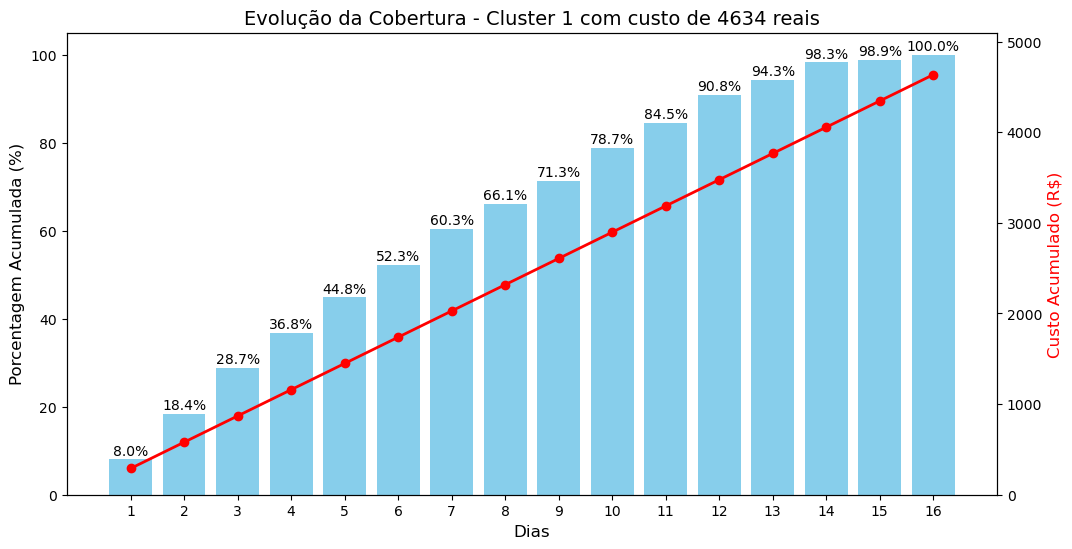

num_pontos_inicial 114


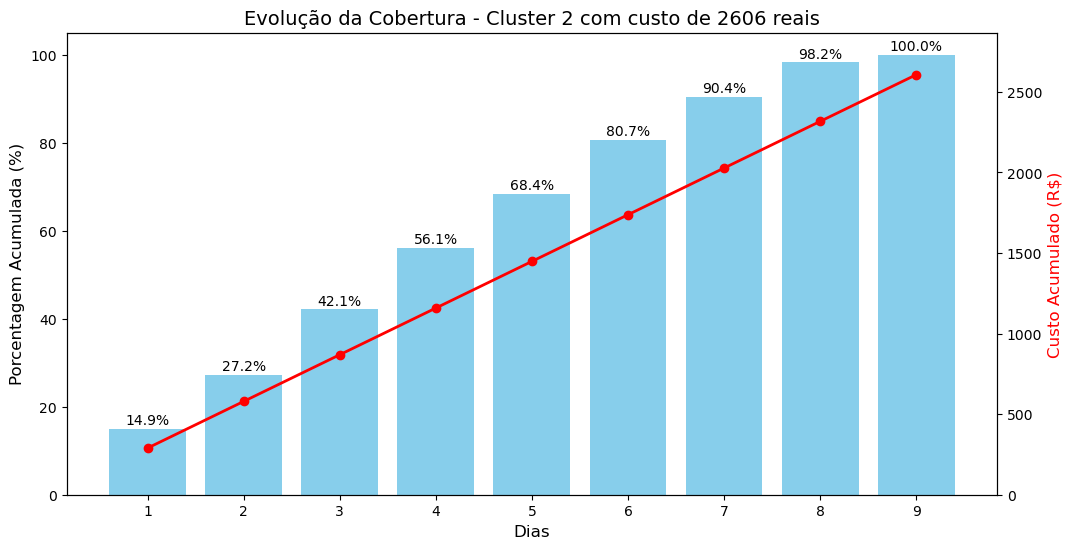

num_pontos_inicial 211
Acumulando as rotas 17 e 18 com 11 amostras


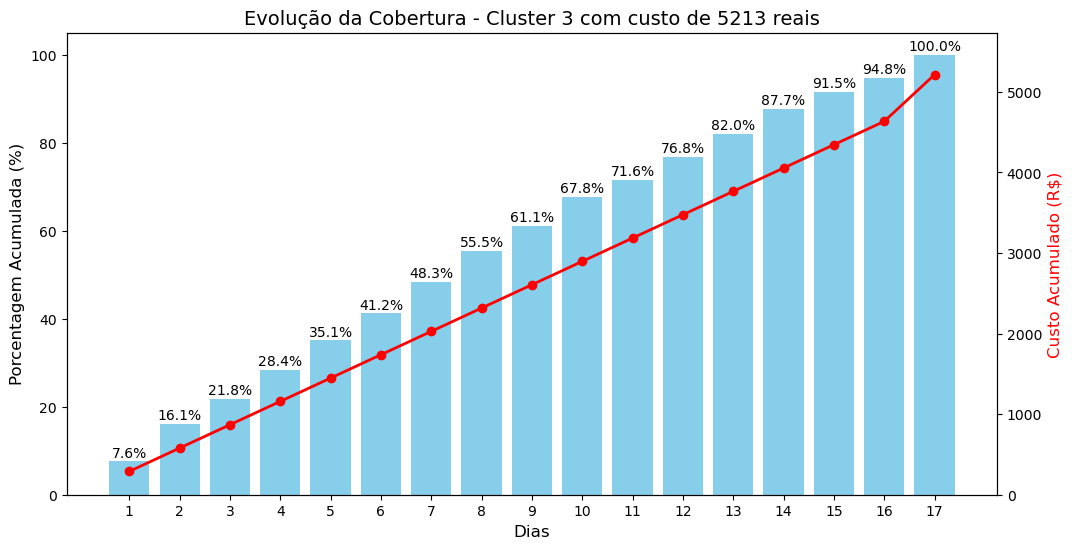

num_pontos_inicial 149


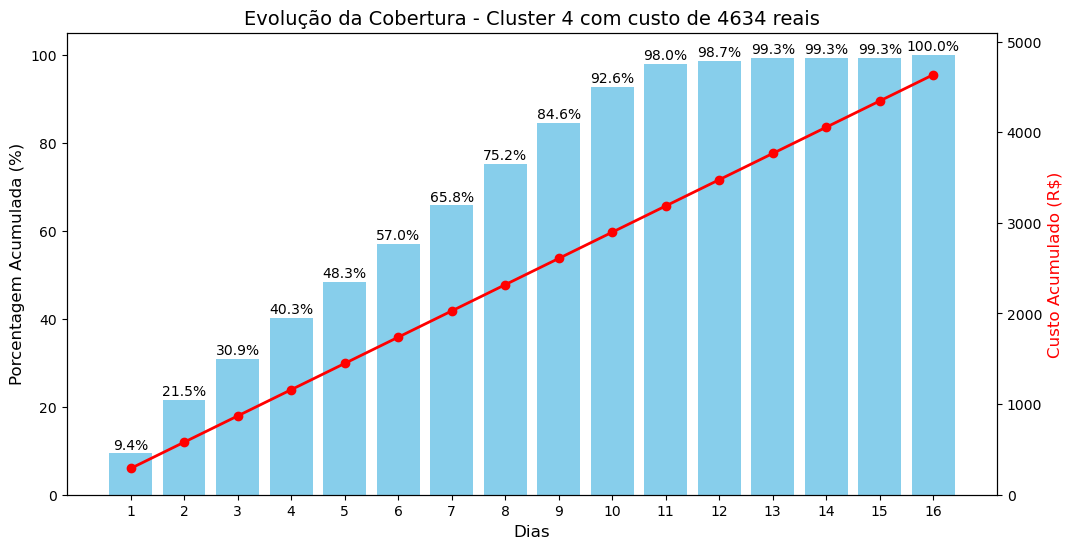

num_pontos_inicial 175
Acumulando as rotas 17 e 18 com 1 amostras


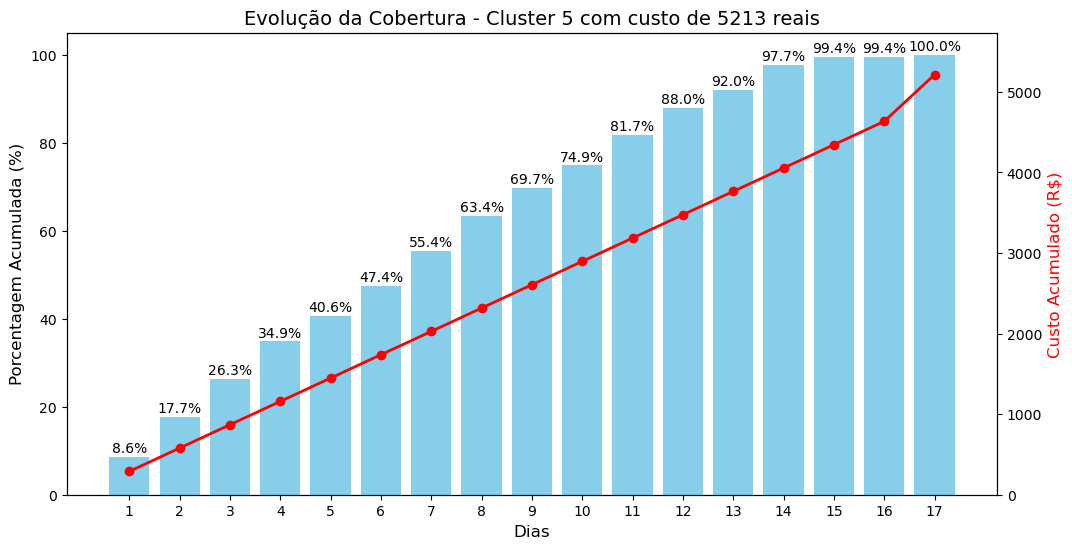

num_pontos_inicial 359
Acumulando as rotas 9 e 10 com 27 amostras
Acumulando as rotas 11 e 12 com 20 amostras
Acumulando as rotas 13 e 14 com 19 amostras
Acumulando as rotas 15 e 16 com 21 amostras
Acumulando as rotas 17 e 18 com 20 amostras
Acumulando as rotas 19 e 20 com 18 amostras
Acumulando as rotas 21 e 22 com 20 amostras
Acumulando as rotas 23, 24 e 25 com 43 amostras
Acumulando as rotas 27, 28 e 29 com 37 amostras
Acumulando as rotas 31, 32 e 33 com 28 amostras
Acumulando as rotas 35, 36 e 37 com 1 amostras


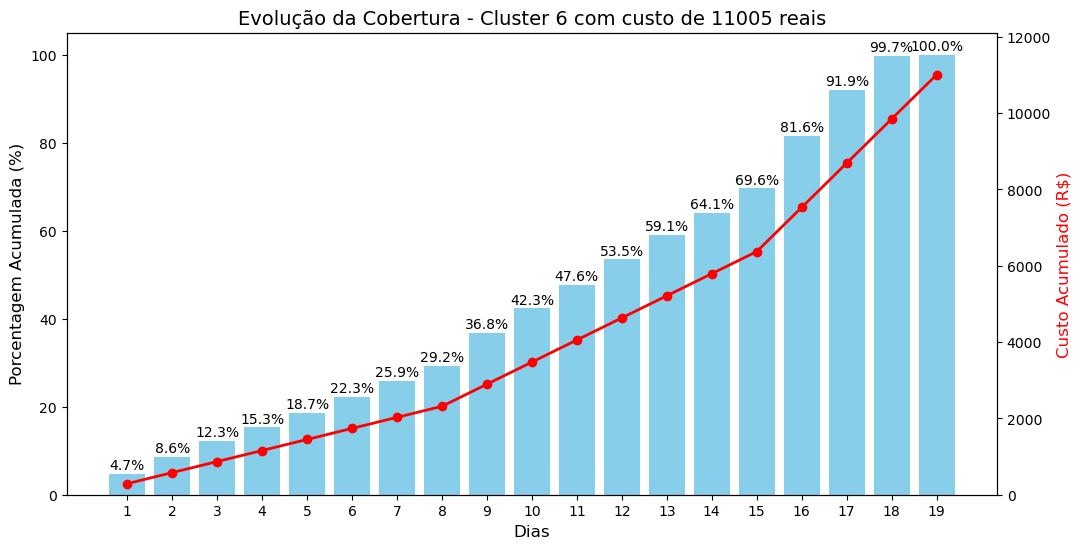

num_pontos_inicial 267
Acumulando as rotas 10 e 11 com 19 amostras
Acumulando as rotas 12 e 13 com 21 amostras
Acumulando as rotas 14 e 15 com 23 amostras
Acumulando as rotas 16 e 17 com 21 amostras
Acumulando as rotas 18 e 19 com 25 amostras
Acumulando as rotas 20 e 21 com 21 amostras
Acumulando as rotas 22 e 23 com 15 amostras
Acumulando as rotas 24 e 25 com 3 amostras


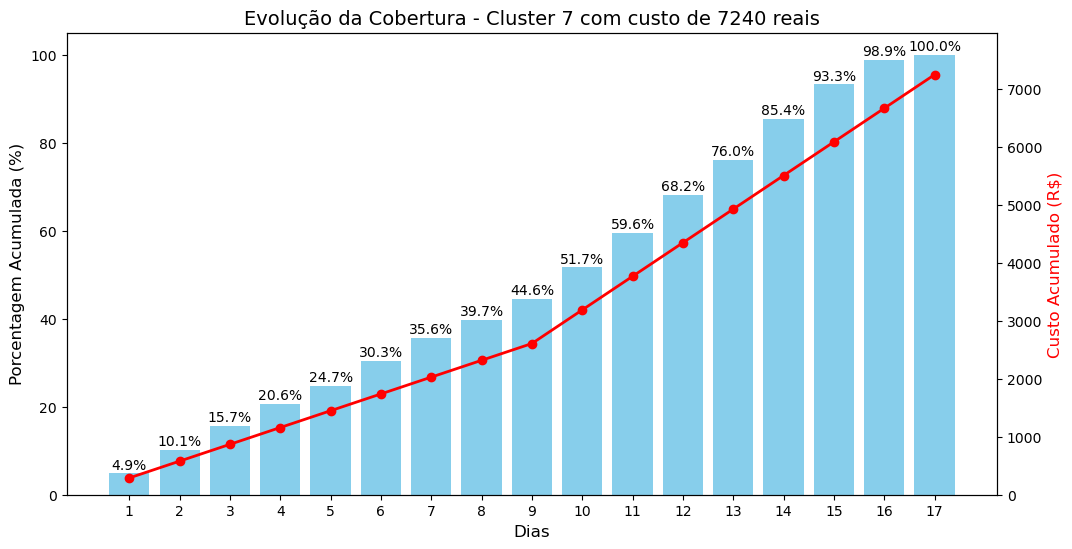

num_pontos_inicial 180


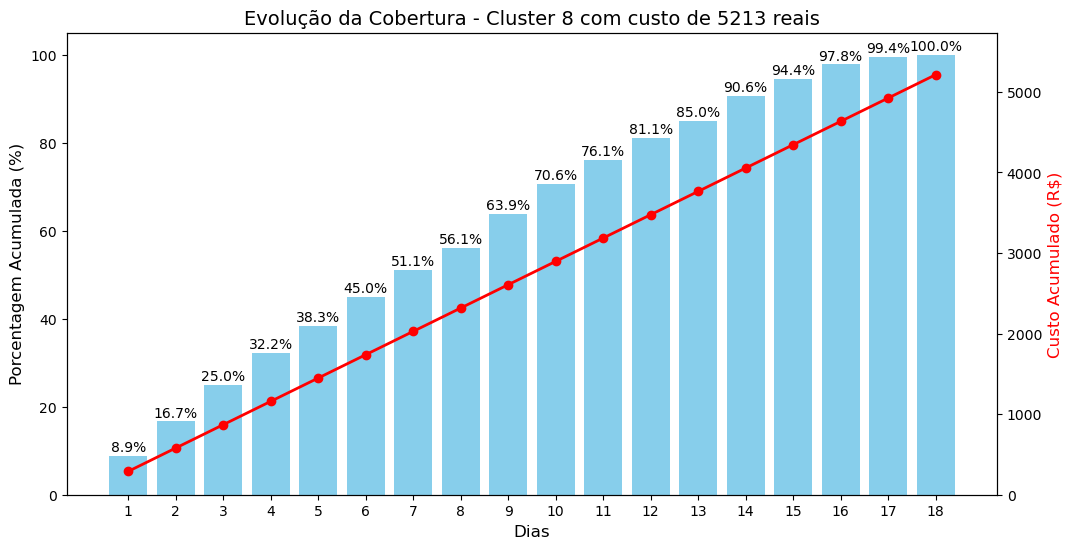

num_pontos_inicial 82


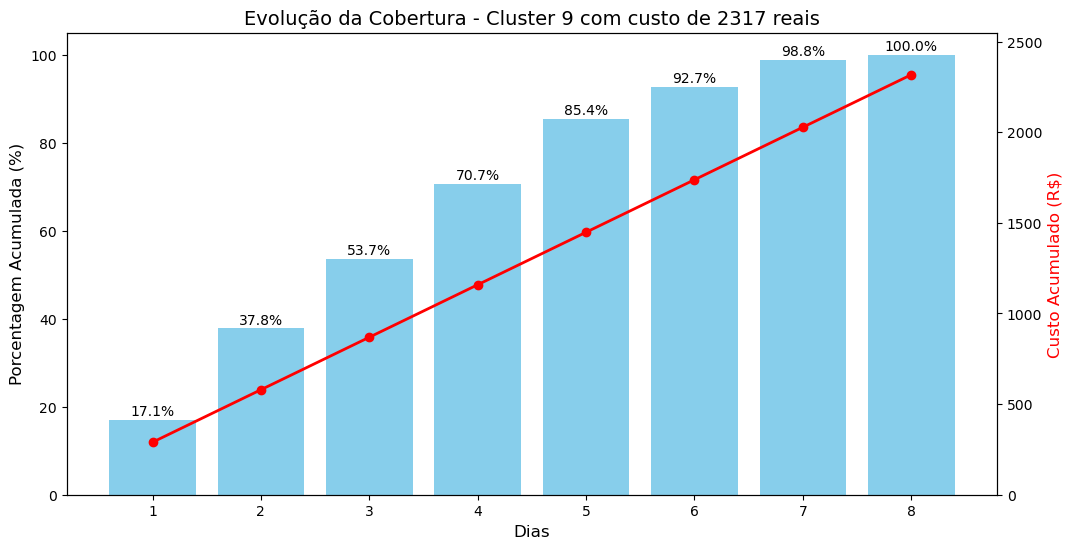

In [24]:
import matplotlib.pyplot as plt
import os

# Loop pelos clusters
for z in range(0, len(mask_posto)):
    # Gerando o "new_points" fora do loop para usar o len() para o "num_pontos_inicial":
    points = Modulo.Region_data_cluster(postos_data, publico_data, n=z+1, regiao=regiao)
    visited_coord = globals()[f'visited_coord_{z}']
    
    # Cria pasta para salvar os gráficos:
    output_dir = f'Formigas_teste_percentual_{regiao}_cluster_{z+1}'
    os.makedirs(output_dir, exist_ok=True)

    # Inicializando o número de pontos e variáveis de controle para cada cluster
    if z == 0:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0
        # Flag para controlar quando somar as rotas
        acumular_rotas = False
        soma_amostras = 0

    if z == 1:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 2:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 3:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 4:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 5:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 6:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 7:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    if z == 8:
        num_pontos_inicial = len(points) -2
        print('num_pontos_inicial', num_pontos_inicial)
        len_selec = 0

        acumular_rotas = False
        soma_amostras = 0

    i = 0  # Inicializa o índice fora do loop para controle manual
    dia_atual = 1  # Variável para simular o dia

    # Inicializando dados para o gráfico de barras
    porcentagens_acumuladas = []
    custos_acumulados = []
    custo_base = 289.63  # Custo base de cada agente
    custo_total = 0  # Inicializando o custo total

    while i < len(visited_coord):
        # Condicional para acumular 3 rotas a partir do 11° dia
        if z == 5 and dia_atual >= 16:
            if i + 3 < len(visited_coord):  # Certifica-se de que existem duas próximas rotas para acumular
                soma_amostras = -4 + len(visited_coord[i]) + len(visited_coord[i + 1]) + len(visited_coord[i + 2]) + len(visited_coord[i + 3])
            elif i + 2 < len(visited_coord):  # Certifica-se de que existem duas próximas rotas para acumular
                soma_amostras = -3 + len(visited_coord[i]) + len(visited_coord[i + 1]) + len(visited_coord[i + 2])
            elif i + 1 < len(visited_coord):  # Se houver apenas duas rotas restantes
                soma_amostras = -2 + len(visited_coord[i]) + len(visited_coord[i + 1])
            else:  # Se for a última rota sem pares
                soma_amostras = len(visited_coord[i]) -1
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1}, {i+2} e {i+3} com {soma_amostras} amostras')
            i += 4  # Pula três iterações
            agentes = 4
        

        # Se z == 0 e for a terceira rota ou mais, acumulamos as amostras de duas em duas até o 10° dia
        elif z == 5 and i > 7 and dia_atual < 16:
            if i + 2 < len(visited_coord):  # Certifica-se de que existe uma próxima rota
                #soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1])
                soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1]) -2

            else:
                soma_amostras = len(visited_coord[i]) -1 # Se for a última rota sem par
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 6 and i > 8:  # Cluster 1, acumular duas rotas após a sexta
            if i + 1 < len(visited_coord):
                soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1]) -2

            else:
                soma_amostras = len(visited_coord[i]) -1
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 2 and i > 15:  # Cluster 1, acumular duas rotas após a sexta
            if i + 1 < len(visited_coord):
                soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1]) -2

            else:
                soma_amostras = len(visited_coord[i]) -1
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2

        elif z == 4 and i > 15:  # Cluster 1, acumular duas rotas após a sexta
            if i + 1 < len(visited_coord):
                soma_amostras = len(visited_coord[i]) + len(visited_coord[i + 1]) -2

            else:
                soma_amostras = len(visited_coord[i]) -1
            len_selec += soma_amostras
            num_pontos_restantes = num_pontos_inicial - len_selec
            print(f'Acumulando as rotas {i+1} e {i+2} com {soma_amostras} amostras')
            i += 2  # Pula duas iterações
            agentes = 2
        else:
            # Caso normal, amostras adicionadas de uma única rota
            amostras_adicionadas = len(visited_coord[i]) -1
            len_selec += amostras_adicionadas
            num_pontos_restantes = num_pontos_inicial - len_selec
            i += 1  # Avança uma iteração normal
            agentes = 1

        # Calcula porcentagem de cobertura:
        porcentagem_coberta = 100 * len_selec / num_pontos_inicial
        porcentagem_restante = 100 - porcentagem_coberta

        # Adiciona as porcentagens ao gráfico de barras
        porcentagens_acumuladas.append(porcentagem_coberta)
        dias = list(range(1, len(porcentagens_acumuladas) + 1))
        
        # Cálculo do custo acumulado
        custo_dia = agentes * custo_base
        custo_total += custo_dia  # Acumula o custo total
        custos_acumulados.append(custo_total)

        dia_atual += 1  # Simula o avanço de dias

    # Gráfico de barras mostrando a evolução da cobertura por dia
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Definindo largura constante e ajustando espaçamento entre as barras
    bar_width = 0.8  # Define a largura das barras
    ax1.bar(dias, porcentagens_acumuladas, color='skyblue', width=bar_width)

    # Adiciona rótulos e título
    ax1.set_xlabel('Dias', fontsize=12)
    ax1.set_ylabel('Porcentagem Acumulada (%)', fontsize=12)
    ax1.set_title(f'Evolução da Cobertura - Cluster {z+1} com custo de {int(custo_total)} reais', fontsize=14)

    # Ajusta o eixo X para mostrar apenas números inteiros (dias)
    ax1.set_xticks(dias)

    # Adiciona rótulos nas barras
    for index, value in enumerate(porcentagens_acumuladas):
        ax1.text(dias[index], value + 1, f'{value:.1f}%', ha='center')

    # Criação do segundo eixo Y para os custos em vermelho
    ax2 = ax1.twinx()
    ax2.plot(dias, custos_acumulados, color='red', linewidth=2, marker='o', label='Custo Acumulado')
    ax2.set_ylabel('Custo Acumulado (R$)', fontsize=12, color='red')

    # Ajusta os limites do eixo para o gráfico de custos
    ax2.set_ylim(0, max(custos_acumulados) * 1.1)


    # Salva o gráfico em uma pasta
    plt.savefig(os.path.join(output_dir, f'Formigas_evolucao_cobertura_cluster_{z+1}.png'))
    plt.show()

In [11]:
len(seq_coord_0)

16

In [12]:
len(seq_coord_1)

9

In [13]:
len(seq_coord_2)

18

In [14]:
len(seq_coord_3)

16

In [15]:
len(seq_coord_4)

18

In [16]:
len(seq_coord_5)

35

In [17]:
len(seq_coord_6)

24

In [18]:
len(seq_coord_7)

18

In [19]:
len(seq_coord_8)

8

### Cronograma:

### Próximas etapas para Abril:

#### 1) Criar uma função para dividir o banco de dados por regiões; [FEITO]

#### 2) Adaptar a função de cálculo de distância no Otimizador; [FEITO]

#### 3) Estratégia para armazenar o caminho para plotar o mapa posteriormente; [FEITO]

#### 4) Adaptar a geração do mapa Folium para o caminho feito pelo Otimizador; [FEITO]

#### 5) Implementar o cálculo de tempo diário dos agentes, parando o algoritmo no momento emq ue se alcança a jornada diária; [FEITO]

#### 6) Estratégia para começar as iterações por alguma unidade de atendimento (onde o agente de saúde saí); [FEITO] - [Obs: essa parte é necessária para fins de código, porém é válido lembrar que, o melhor caminho é independente do ponto de partida]

#### 7) Verificar o funcionamento da função "expediente_agente", se está fazendo certo; [FEITO]

#### 8) Adaptar a função stack para uma subregião inteira (m = len(data when regiao == Sudeste); [FEITO]

#### 9) Testar o incremento do raio. [FEITO]

### Próximas etapas para Maio:

#### 1) Unir as funções de "ant_colony_optimization" e "best_way", isso para melhorar a funcionalidade do futuro loop; [FEITO]

#### 2) Gerar um .txt como um relatório de: mudança de raio, melhor caminho e etc... Para fins de registro! [FEITO]

#### 3) Armazenar cada "best_path" após cada loop; [FEITO]

#### 4) Analizar possíveis variáveis que serão necessárias para as etapas finais e gerá-las no Otimizador; [FEITO]

#### 5) Usar o "best_path" para uma próxima rodada, para não passar por pontos já visitados; [FEITO]

##### 5.1) Uma abordagem: montar um "new_stack_data" retirando os pontos de stack_data[best_path] que entra num novo loop (2° dia do agente) no otmizador. [FEITO]

##### 5.2) Calculo do tempo total, verificar as saídas; [FEITO]

##### 5.3) Adaptar as novas funções no Modulo.py; [FEITO]

##### 5.4) O que acontece se o loop percorre todos os pontos? Usar o "break"? [FEITO]

#### 6) Automatizar a geração dos Mapas e salvar em cada iteração, para mostrar a evolução da cubertura; [FEITO]

#### 7) Retirada informações desnecessárias para otimizar a execução do script: [FEITO]

###### 7.1) retirada dos prints e variáveis densecessárias; [FEITO]
###### 7.2) separação das funções "ant_colony_optimization" e "best_way"; [FEITO] 
###### 7.3) retirada do relatório .txt (gera muitos arquivos no Super loop, poluindo as informações) [FEITO]

#### Extra: Tentar implementar o Cython para otimizar os cálculos (muito tempo para gerar o resultado devido a quantidade de amostra

### Próximas etapas para Junho:

#### 1) Desenvolver gráficos de evolução de porcentagem de cobertura vacinal; [FEITO]

#### 2) Salvar a variável "seq_coord" para ser usado nos próximos itens; [NÃO É NECESSÁRIO]

#### 3) Discução sobre os gráficos finais; [FEITO]

#### 4) Estudo comparativo entre quantidade de agentes, custo e tempo de cobertura; [FEITO]

##### 4.1) gráfico de porcentagem por dia; [FEITO]
##### 4.2) gráfico de quilometragem por dia; [FEITO]
##### 4.3) custo dos agentes. [FEITO]

#### 5) Testes para diferentes Hiperparâmetros; [PARCIALMENTE FEITO]

#### 6) Plotar um mapa com cada região em uma cor. [FEITO]


### END